In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.cosmology import Planck15
from scipy.special import sph_harm_y
import pint
from pint.models import get_model
import glob, os 
from astropy import units as u
from astropy.coordinates import SkyCoord
from gwbird import detectors
from gwbird import skymap
from gwbird import utils
from gwbird.overlap import Response
from gwbird.nell import AngularResponse
from gwbird import overlap
from gwbird import nell
from gwbird import skymap
from gwbird import utils
from gwbird import detectors
from gwbird import pls
from gwbird.skymap import AngularPatternFunction, Basis
from gwbird.nell import AngularResponse, Sensitivity_ell
import matplotlib.cm as cm
from scipy.integrate import dblquad
#import beepy
from scipy.integrate import simpson

plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# code to see the effect of the pulsar term

In [3]:
def pairwise_overlap_fL(fLc, pi, pj, pol, psi=0):


        def gamma_integrand(fLc, theta, phi, psi, p1, p2, pol):
            Fp1 = AngularPatternFunction.F_pulsar(theta, phi, psi, p1)
            Fp2 = AngularPatternFunction.F_pulsar(theta, phi, psi, p2)
            fLc = fLc.reshape(len(fLc), 1, 1)

            Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]

            exp1 =(1-np.exp(-2j*np.pi*fLc*(1+(np.einsum('iab,i->ab', Omega, pi)))))
            exp2 =(1-np.exp(2j*np.pi*fLc*(1+(np.einsum('iab,i->ab', Omega, pj)))))
    

            delta = 1 if np.array_equal(p1, p2) else 0
            k = 1 + delta

            if pol == '+':
                gamma_ij = 3 * (Fp1[0] * Fp2[0])  * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            elif pol == 'cross':
                gamma_ij = 3 * (Fp1[1] * Fp2[1])  * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            elif pol == 'y':
                gamma_ij = 3 * (Fp1[2] * Fp2[2]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            elif pol == 'y':
                gamma_ij = 3 * (Fp1[3] * Fp2[3]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            elif pol == 'b':
                gamma_ij = 3 * Fp1[4] * np.conj(Fp2[4]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1*exp2
                return gamma_ij
            elif pol == 'l': 
                gamma_ij = 3 * Fp1[5] * np.conj(Fp2[5]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1*exp2
                return gamma_ij
            if pol == 't':
                gamma_ij = 3 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1])  * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            elif pol == 'v':
                gamma_ij = 3 * (Fp1[2] * Fp2[2] + Fp1[3] * Fp2[3]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1* exp2
                return gamma_ij
            else:
                raise ValueError('Unknown polarization')

        def gamma(p1, p2, fLc, pol, psi):
            theta = np.linspace(0, np.pi, 100)
            phi = np.linspace(0, 2*np.pi, 100)
            Theta, Phi = np.meshgrid(theta, phi)
            integrand = gamma_integrand(fLc, Theta, Phi, psi, p1, p2, pol)
            #integral = np.trapezoid(np.trapezoid(integrand, theta), phi)
            integral = simpson(simpson(integrand, theta, axis=1), phi)
            return integral

        return gamma(pi, pj, fLc, pol, psi)

In [3]:
N, p, d = detectors.get_NANOGrav_pulsars()
f = np.logspace(-9, -7, 100)

2025-04-16 15:22:10.371 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


In [5]:
fLc = np.linspace(0.01, 20, 100)

alpha_ij = []
gamma_plus = []
gamma_y = []
gamma_b = []
gamma_l = []

for i in range(len(p)):
    for j in range(i+1, len(p)):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))
        gamma_plus.append(pairwise_overlap_fL(fLc, p[i], p[j], '+'))
        gamma_y.append(pairwise_overlap_fL(fLc, p[i], p[j], 'y'))
        gamma_b.append(pairwise_overlap_fL(fLc, p[i], p[j], 'b'))
        gamma_l.append(pairwise_overlap_fL(fLc, p[i], p[j], 'l'))


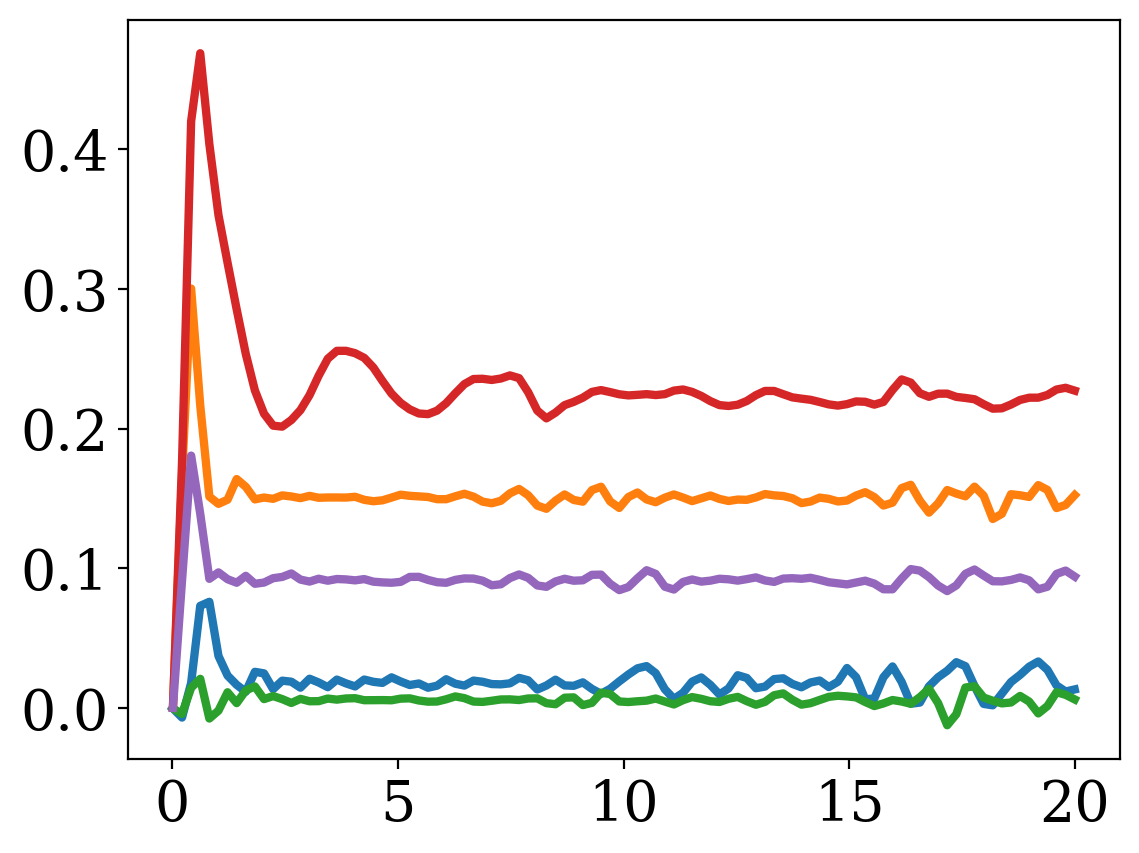

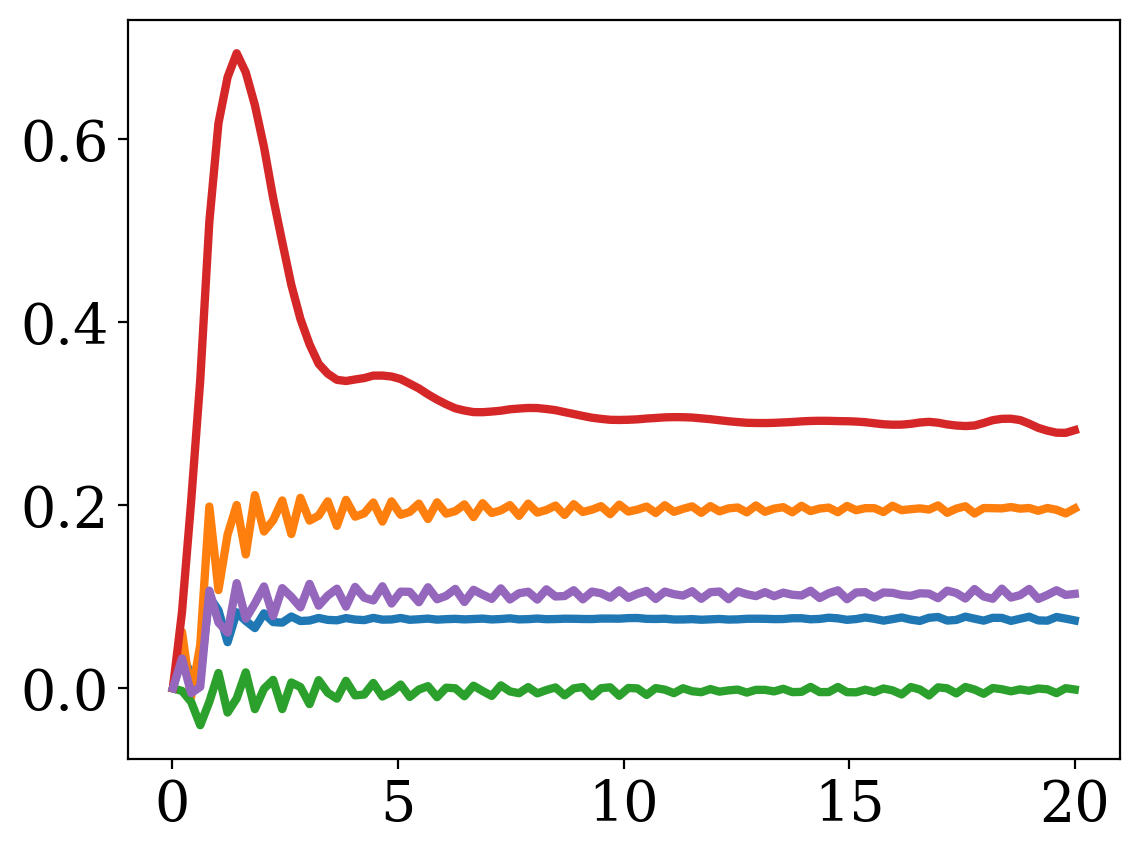

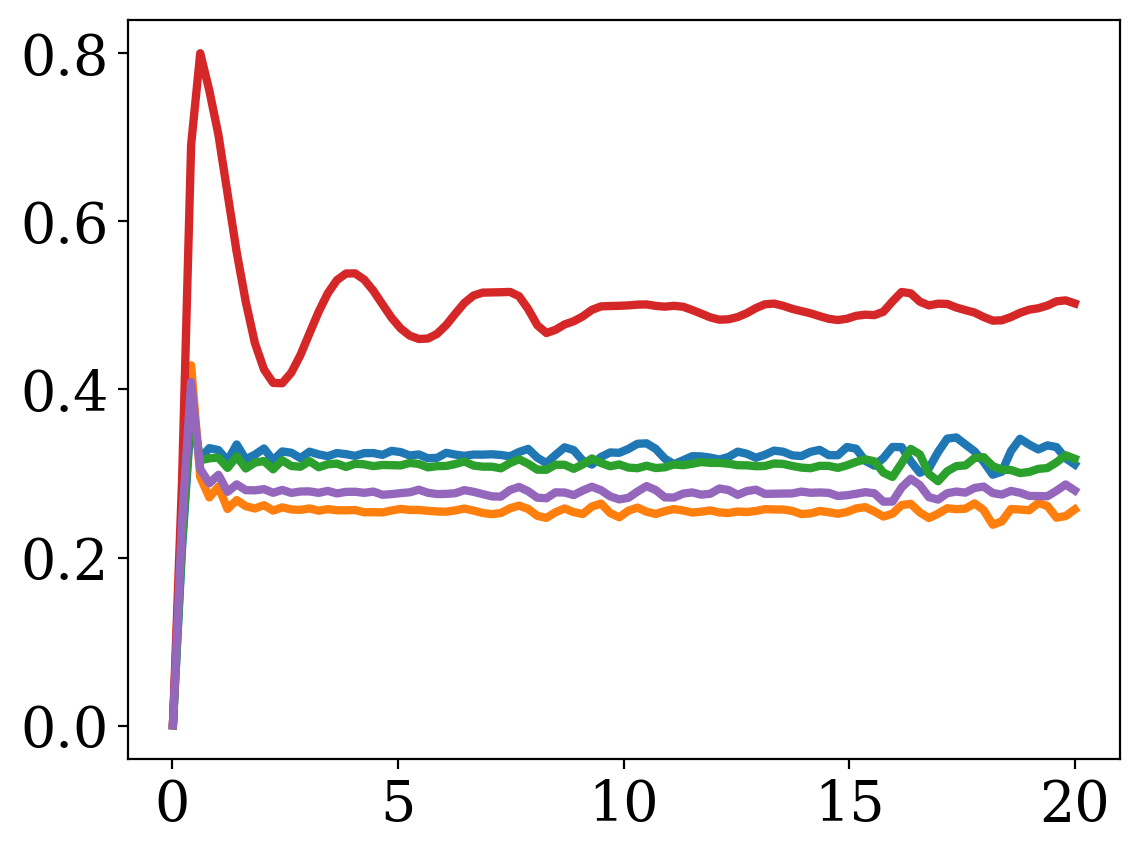

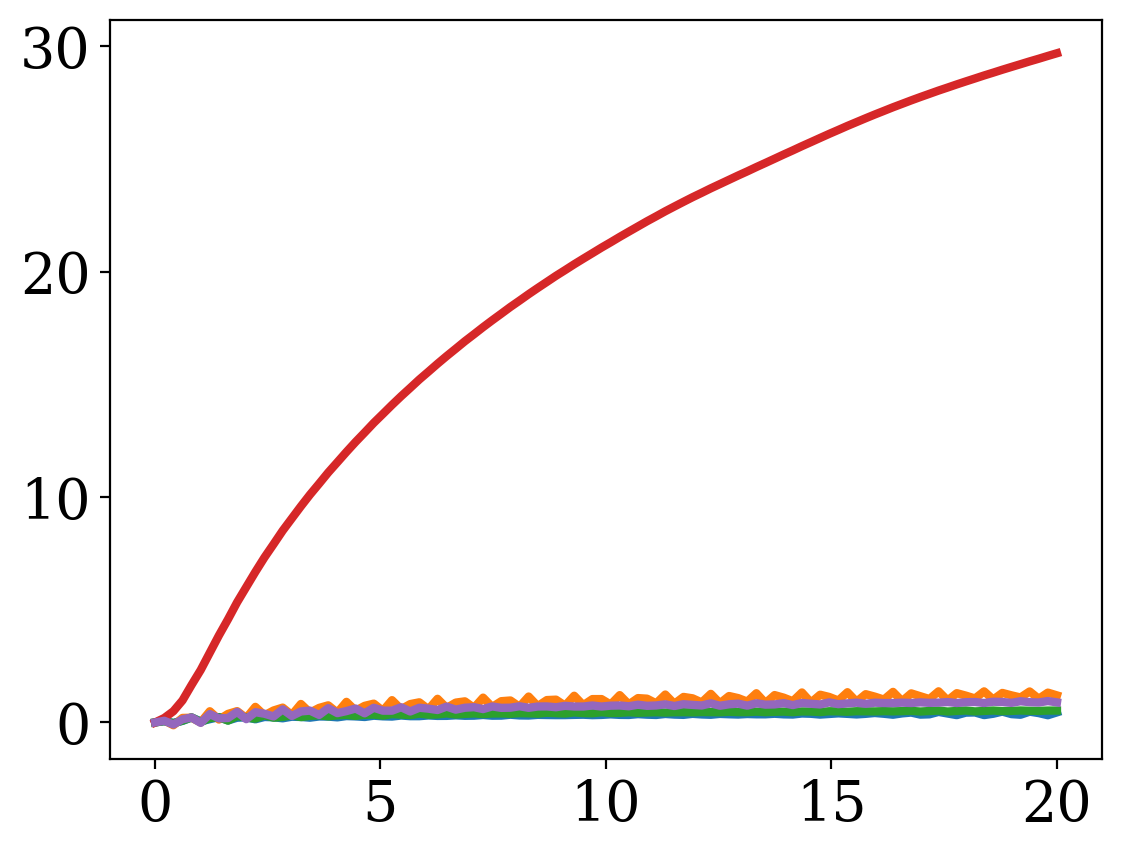

In [6]:
# plot the overlap function as a function of fLc    

plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_plus[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))

plt.show()

plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_y[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))
plt.show()

plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_b[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))
plt.show()

plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_l[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))
    

In [7]:
fLc = np.linspace(0.01, 20, 100)

alpha_ij = []
gamma_t = []
gamma_v = []


for i in range(len(p)):
    for j in range(i+1, len(p)):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))
        gamma_t.append(pairwise_overlap_fL(fLc, p[i], p[j], 't'))
        gamma_v.append(pairwise_overlap_fL(fLc, p[i], p[j], 'v'))

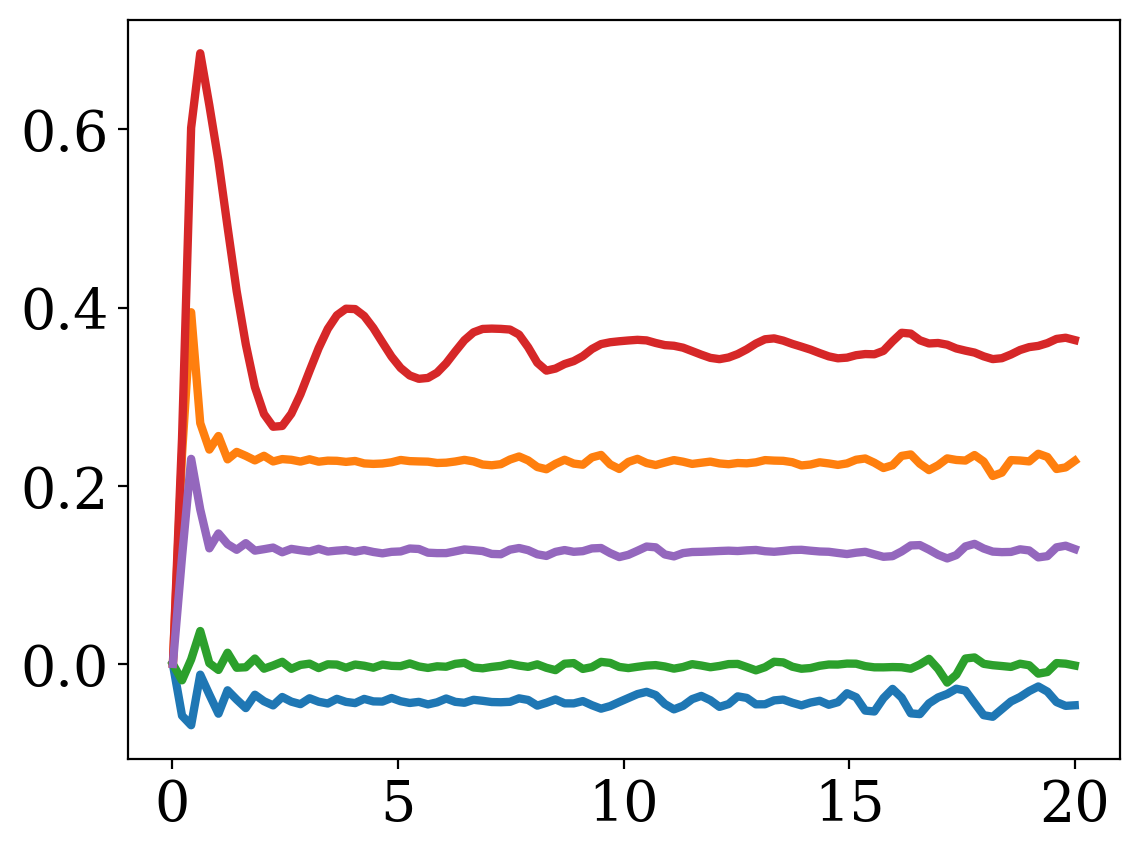

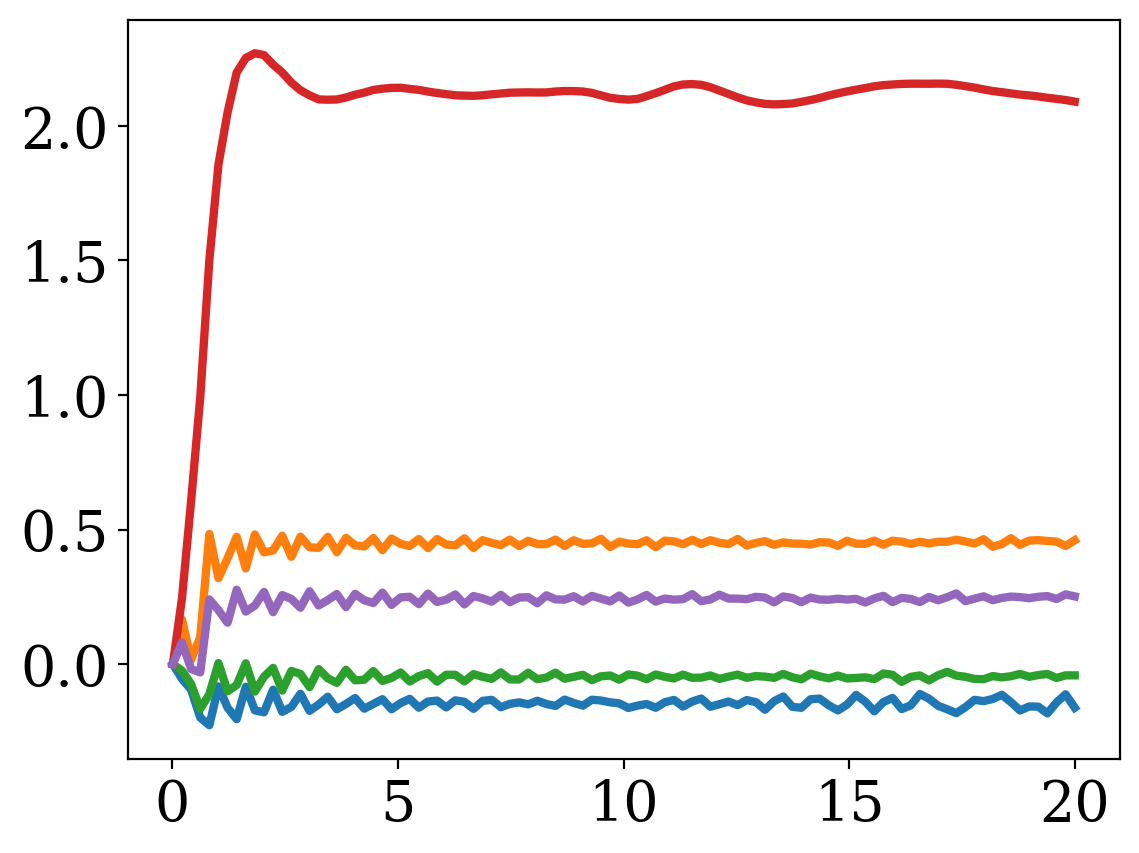

In [8]:
plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_t[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))
plt.show()

plt.figure()
for i in range(5):
    plt.plot(fLc, gamma_v[i], label=r'$\alpha_{ij}=$'+str(np.degrees(alpha_ij[i])))
plt.show()

In [141]:
def pairwise_overlap(f, pi, pj, Di, Dj, pol, psi=0):


        def gamma_integrand(f, theta, phi, psi, p1, p2, Di, Dj, pol):
            Fp1 = AngularPatternFunction.F_pulsar(theta, phi, psi, p1)
            Fp2 = AngularPatternFunction.F_pulsar(theta, phi, psi, p2)
            f = f.reshape(len(f), 1, 1)

            Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]

            exp1 =(1-np.exp(-2j*np.pi*f*Di*(1+(np.einsum('iab,i->ab', Omega, pi)))/c))
            exp2 =(1-np.exp(2j*np.pi*f*Dj*(1+(np.einsum('iab,i->ab', Omega, pj)))/c))

            delta = 1 if np.array_equal(p1, p2) else 0
            k = 1 + delta

            if pol == 't':
                gamma_ij = 3 * (Fp1[0] * np.conj(Fp2[0]) + Fp1[1] * np.conj(Fp2[1])) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            if pol == '+':
                gamma_ij = 3 * (Fp1[0] * np.conj(Fp2[0]) ) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            elif pol == 'v':
                gamma_ij = 3 * (Fp1[2] * np.conj(Fp2[2]) + Fp1[3] * np.conj(Fp2[3])) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            elif pol == 'y':
                gamma_ij = 3 * (Fp1[3] * np.conj(Fp2[3])) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2 
                return gamma_ij
            elif pol == 's':
                gamma_ij = 3 * Fp1[4] * np.conj(Fp2[4]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            elif pol == 'l': 
                gamma_ij = 3 * Fp1[5] * np.conj(Fp2[5]) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            elif pol == 'I':
                gamma_ij = 3 * (Fp1[0] * np.conj(Fp2[0]) + Fp1[1] * np.conj(Fp2[1])) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            elif pol == 'V':
                gamma_ij = 3j * (Fp1[0] * np.conj(Fp2[1]) - Fp1[1] * np.conj(Fp2[0])) * (1/(8*np.pi)) * np.sin(theta) * k * exp1 * exp2
                return gamma_ij
            else:
                raise ValueError('Unknown polarization')

        def gamma(p1, p2, Di, Dj, f, pol, psi):
            theta = np.linspace(0, np.pi, 100)
            phi = np.linspace(0, 2*np.pi, 100)
            Theta, Phi = np.meshgrid(theta, phi)
            integrand = gamma_integrand(f, Theta, Phi, psi, p1, p2, Di, Dj, pol)
            integral = np.trapezoid(np.trapezoid(integrand, theta), phi)
            return np.real(integral)

        return gamma(pi, pj, Di, Dj, f, pol, psi)
    

In [58]:
N, p, d = detectors.get_NANOGrav_pulsars()
f = np.logspace(-9, -7, 100)

# check if fL/c > 10 for all the pulsars
# fL = np.zeros(len(p))
# for i in range(len(p)):
#     fL[i] = f[0]*d[i]/c
#     print(f[0]*d[i]/c)


2025-03-21 10:28:38.290 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


3.380934335923993e+19


In [111]:
gamma_ij_y = []
alpha_ij = []

for i in range(len(p)):
    for j in range(i+1, len(p)):
        gamma_ij_y.append(pairwise_overlap(f, p[i], p[j], d[i], d[j], '+'))
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))

gamma_ij_y = np.array(gamma_ij_y)
alpha_ij = np.array(alpha_ij)

In [112]:
print(gamma_ij_y.shape)
print(alpha_ij.shape)

(1770, 100)
(1770,)


In [113]:
print(np.max(gamma_ij_y))

0.30007522985729007


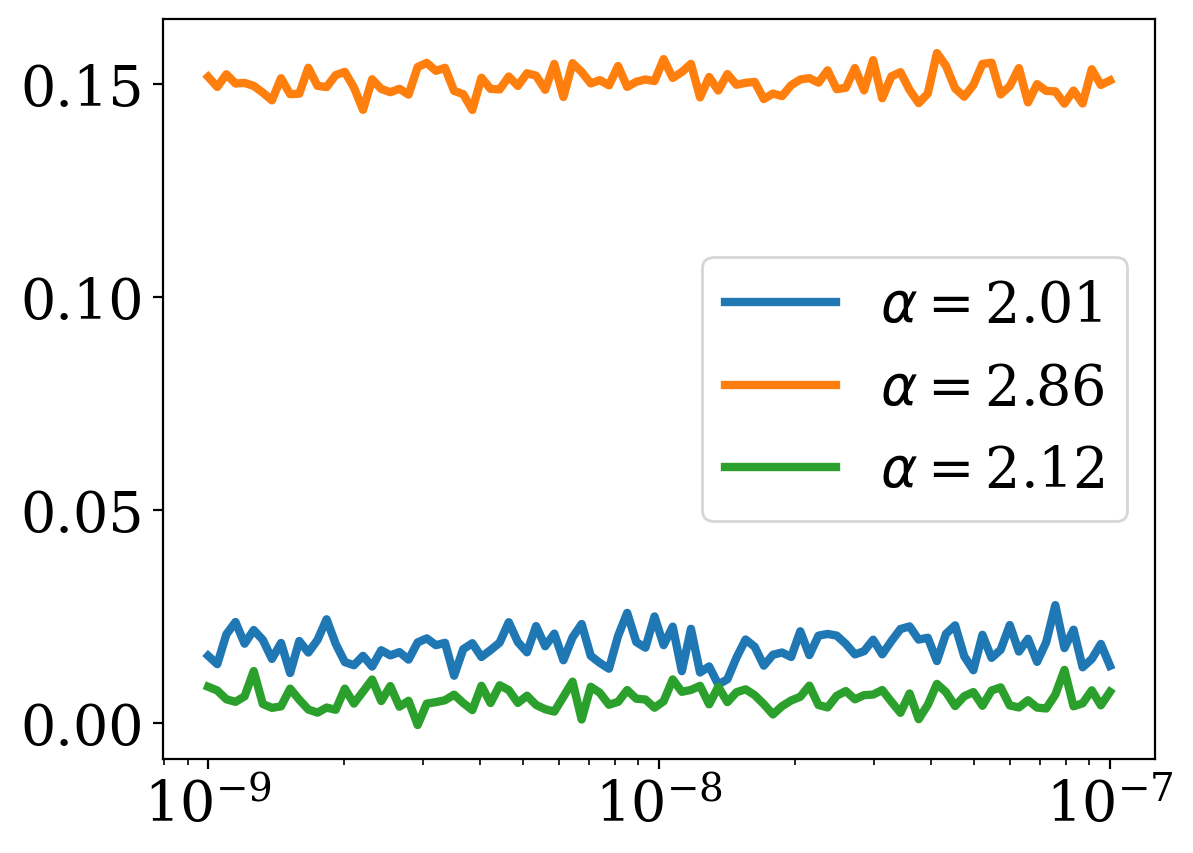

In [114]:


# plot the frequency vs gamma_ij for these values of alpha

plt.figure()
plt.plot(f, gamma_ij_y[0,:], label=r'$\alpha = $' + str(np.round(alpha_ij[0], 2)))
plt.plot(f, gamma_ij_y[1,:], label=r'$\alpha = $' + str(np.round(alpha_ij[1], 2)))
plt.plot(f, gamma_ij_y[2,:], label=r'$\alpha = $' + str(np.round(alpha_ij[2], 2)))
plt.xscale('log')
plt.legend()
plt.show()




In [144]:


# Compute the overlap reduction function between all pairs of pulsars

gamma_ij_t = []
gamma_ij_v = []
gamma_ij_s = []
gamma_ij_t_nof = []
gamma_ij_v_nof = []
gamma_ij_s_nof = []
alpha_ij = []

for i in range(len(p)):
    for j in range(i+1, len(p)):
        gamma_ij_t.append(pairwise_overlap(f, p[i], p[j], d[i], d[j], 't'))
        gamma_ij_v.append(pairwise_overlap(f, p[i], p[j], d[i], d[j], 'v'))
        gamma_ij_s.append(pairwise_overlap(f, p[i], p[j], d[i], d[j], 's'))
        gamma_ij_t_nof.append(Response.pairwise_overlap(f, p[i], p[j], 't'))
        gamma_ij_v_nof.append(Response.pairwise_overlap(f, p[i], p[j], 'v'))
        gamma_ij_s_nof.append(Response.pairwise_overlap(f, p[i], p[j], 's'))
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))

gamma_ij_t = np.array(gamma_ij_t)
gamma_ij_v = np.array(gamma_ij_v)
gamma_ij_s = np.array(gamma_ij_s)
gamma_ij_t_nof = np.array(gamma_ij_t_nof)
gamma_ij_v_nof = np.array(gamma_ij_v_nof)
gamma_ij_s_nof = np.array(gamma_ij_s_nof)
alpha_ij = np.array(alpha_ij)

(1770, 100)
(1770,)
(array([1344]),)
(array([1308]),)
(array([745]),)


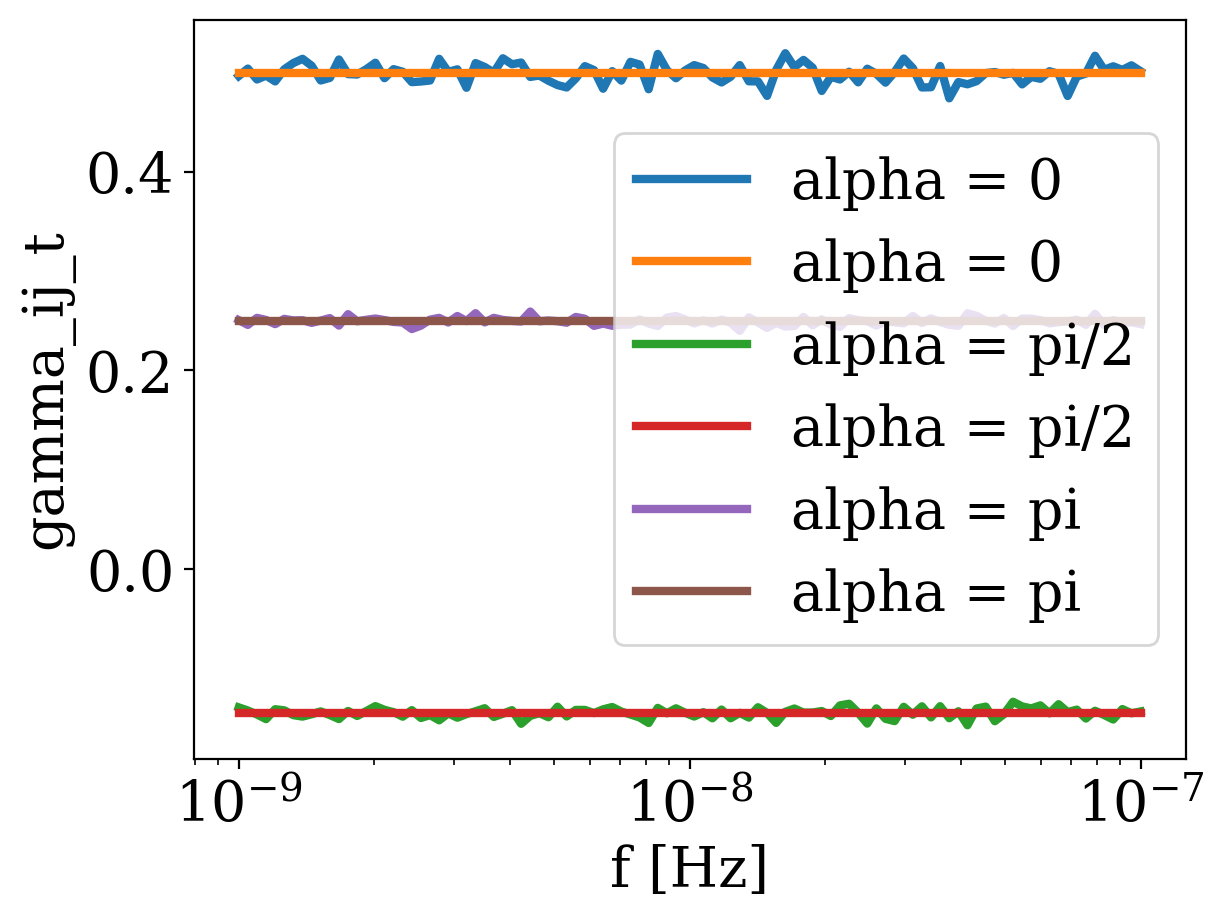

In [145]:
print(gamma_ij_t.shape)
# print(gamma_ij_v.shape)
# print(gamma_ij_s.shape)
print(alpha_ij.shape)

# plot the overlap reduction function for pulsars that distances alpha \sim 0 , alpha sim \pi/2 and \\

# find them in the dataset of pulsars

alpha_0 = np.where(alpha_ij < 0.02)
alpha_pi2 = np.where(np.abs(alpha_ij - np.pi/2) < 0.0005)
alpha_pi = np.where(np.abs(alpha_ij - np.pi) < 0.04)

print(alpha_0)
print(alpha_pi2)
print(alpha_pi)

# for these vaues of alpha, plot the overlap reduction function

plt.figure()
plt.plot(f, gamma_ij_t[alpha_0[0][0]], label='alpha = 0')
plt.plot(f, gamma_ij_t_nof[alpha_0[0][0]]*np.ones(len(f)), label='alpha = 0')
plt.plot(f, gamma_ij_t[alpha_pi2[0][0]], label='alpha = pi/2')
plt.plot(f, gamma_ij_t_nof[alpha_pi2[0][0]]*np.ones(len(f)), label='alpha = pi/2')
plt.plot(f, gamma_ij_t[alpha_pi[0][0]], label='alpha = pi')
plt.plot(f, gamma_ij_t_nof[alpha_pi[0][0]]*np.ones(len(f)), label='alpha = pi')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('gamma_ij_t')
plt.legend()

In [146]:
mean = np.mean(gamma_ij_t[alpha_0[0][0]])
print(mean)
print(np.mean(gamma_ij_t_nof[alpha_0[0][0]]))


0.498476384221029
0.4989989417848118


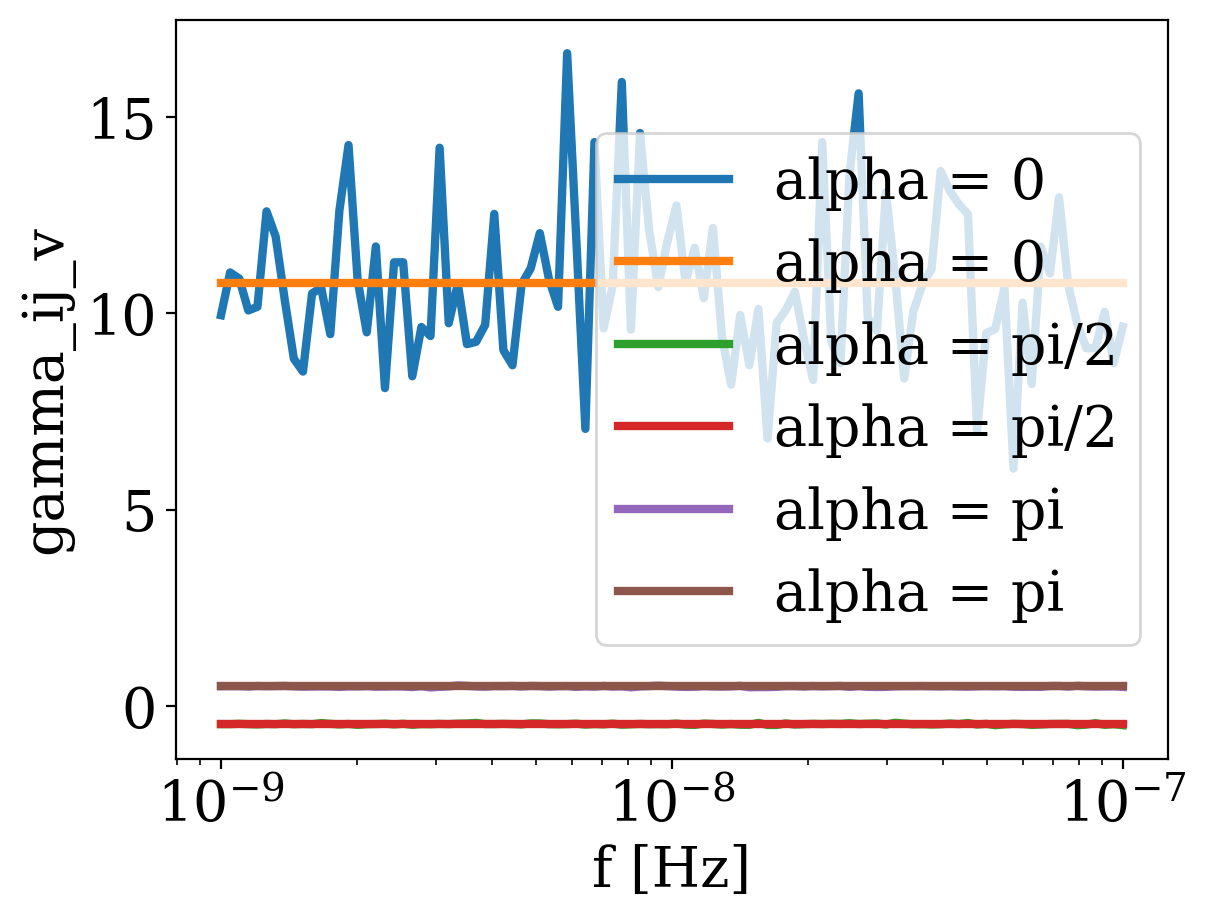

In [147]:
plt.figure()
plt.plot(f, gamma_ij_v[alpha_0[0][0]], label='alpha = 0')
plt.plot(f, gamma_ij_v_nof[alpha_0[0][0]]*np.ones(len(f)), label='alpha = 0')
plt.plot(f, gamma_ij_v[alpha_pi2[0][0]], label='alpha = pi/2')
plt.plot(f, gamma_ij_v_nof[alpha_pi2[0][0]]*np.ones(len(f)), label='alpha = pi/2')
plt.plot(f, gamma_ij_v[alpha_pi[0][0]], label='alpha = pi')
plt.plot(f, gamma_ij_v_nof[alpha_pi[0][0]]*np.ones(len(f)), label='alpha = pi')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('gamma_ij_v')
plt.legend()

In [148]:
mean = np.mean(gamma_ij_v[alpha_0[0][0]])
print(mean)
print(np.mean(gamma_ij_v_nof[alpha_0[0][0]]))

10.65541124511592
10.771058754872408


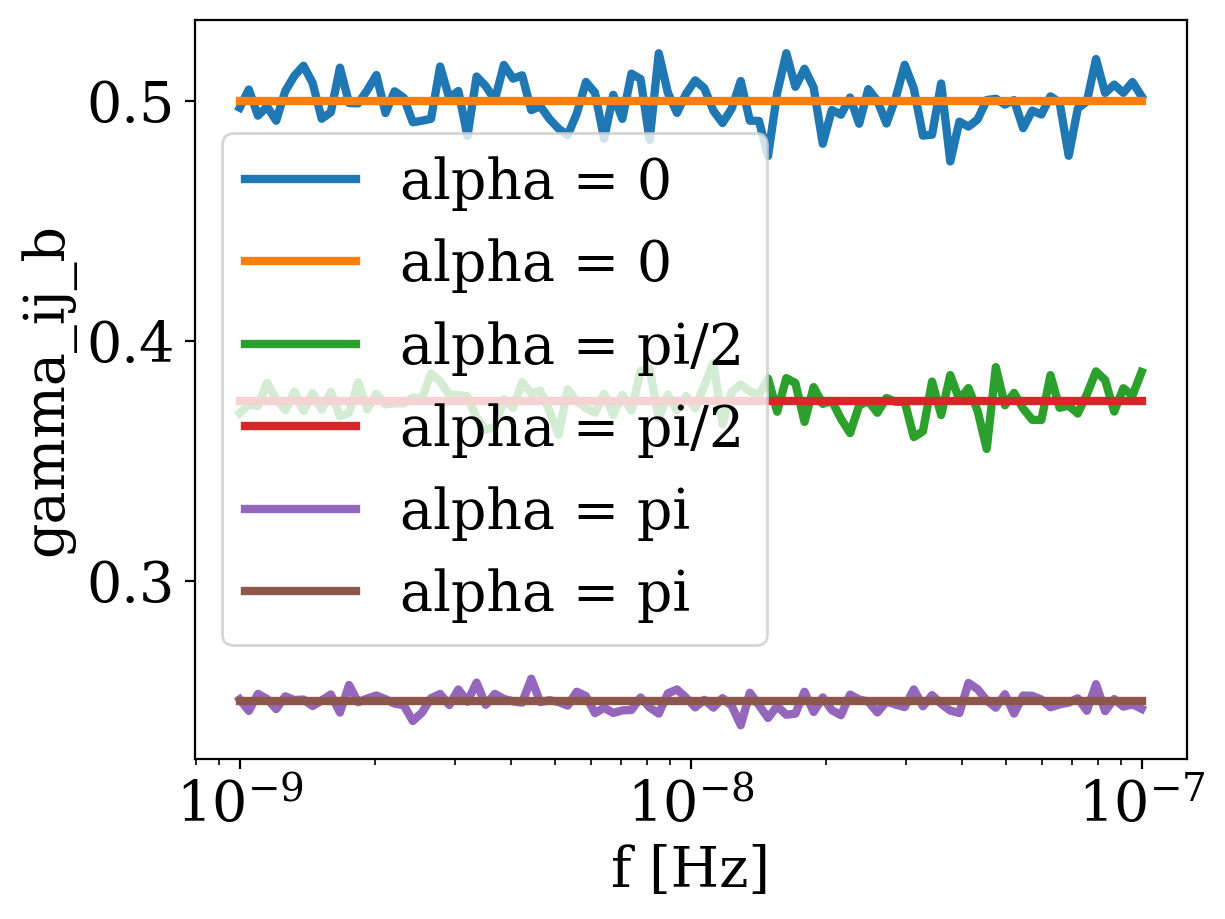

In [149]:
plt.figure()
plt.plot(f, gamma_ij_s[alpha_0[0][0]], label='alpha = 0')
plt.plot(f, gamma_ij_s_nof[alpha_0[0][0]]*np.ones(len(f)), label='alpha = 0')
plt.plot(f, gamma_ij_s[alpha_pi2[0][0]], label='alpha = pi/2')
plt.plot(f, gamma_ij_s_nof[alpha_pi2[0][0]]*np.ones(len(f)), label='alpha = pi/2')
plt.plot(f, gamma_ij_s[alpha_pi[0][0]], label='alpha = pi')
plt.plot(f, gamma_ij_s_nof[alpha_pi[0][0]]*np.ones(len(f)), label='alpha = pi')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('gamma_ij_b')
plt.legend()

In [154]:
mean = np.mean(gamma_ij_s[alpha_0[0][0]])
print(mean)
print(np.mean(gamma_ij_s_nof[alpha_0[0][0]]))

0.49941942589160293
0.49994953444618195


In [151]:
gamma_ij_l = []
gamma_ij_l_nof = []
alpha_ij_new = []

for i in range(len(p)):
    for j in range(i+1, len(p)):
        gamma_ij_l.append(pairwise_overlap(f, p[i], p[j], d[i], d[j], 'l'))
        gamma_ij_l_nof.append(Response.pairwise_overlap(f, p[i], p[j], 'l'))
        alpha_ij_new.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))


(array([1344]),)
(array([1308]),)
(array([745]),)


Text(0, 0.5, 'gamma_ij_l')

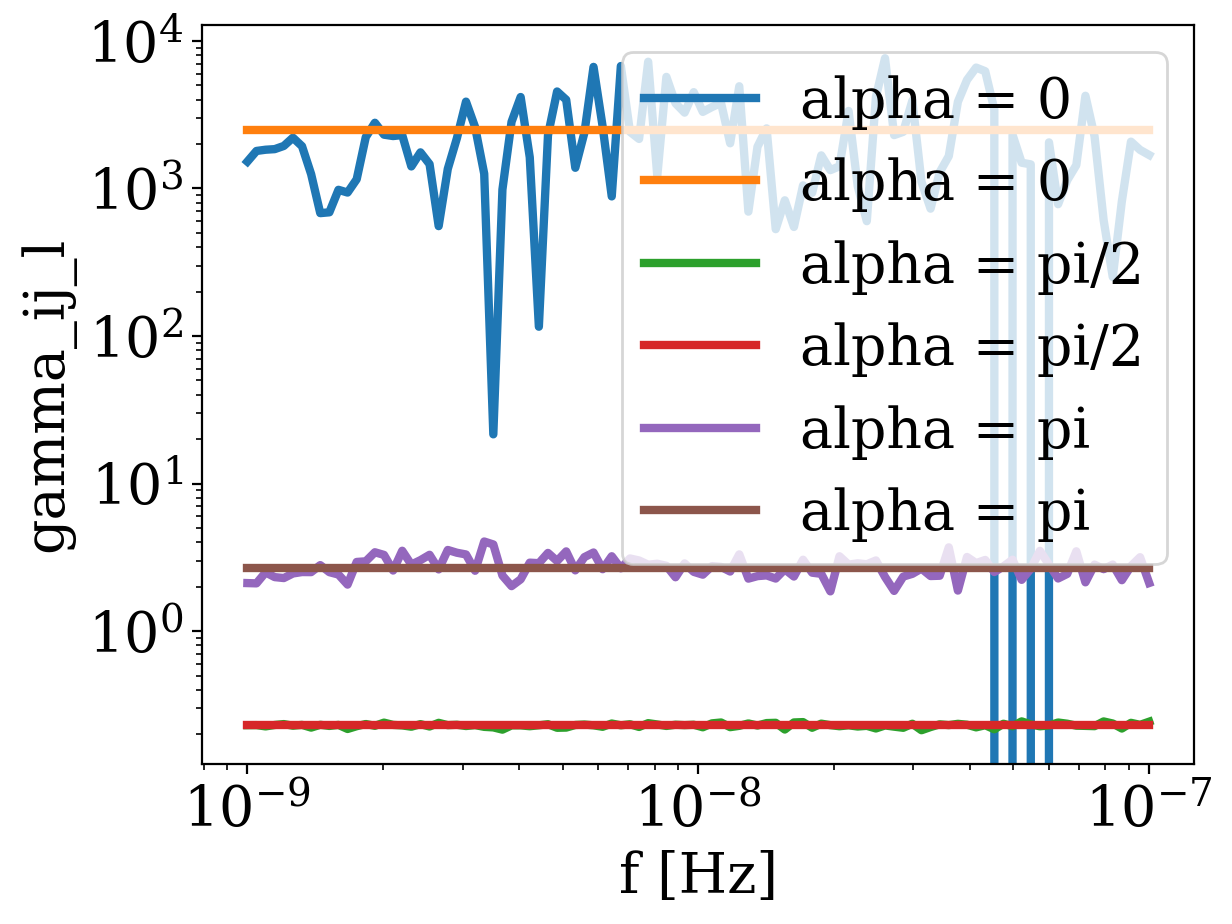

In [152]:
alpha_ij_new = np.array(alpha_ij_new)
gamma_ij_l = np.array(gamma_ij_l)
gamma_ij_l_nof = np.array(gamma_ij_l_nof)

alpha_0 = np.where(alpha_ij_new < 0.02)
alpha_pi2 = np.where(np.abs(alpha_ij_new - np.pi/2) < 0.0005)
alpha_pi = np.where(np.abs(alpha_ij_new - np.pi) < 0.04)

print(alpha_0)
print(alpha_pi2)
print(alpha_pi)

plt.figure()
plt.plot(f, gamma_ij_l[alpha_0[0][0]], label='alpha = 0')
plt.plot(f, gamma_ij_l_nof[alpha_0[0][0]]*np.ones(len(f)), label='alpha = 0')
plt.plot(f, gamma_ij_l[alpha_pi2[0][0]], label='alpha = pi/2')
plt.plot(f, gamma_ij_l_nof[alpha_pi2[0][0]]*np.ones(len(f)), label='alpha = pi/2')
plt.plot(f, gamma_ij_l[alpha_pi[0][0]], label='alpha = pi')
plt.plot(f, gamma_ij_l_nof[alpha_pi[0][0]]*np.ones(len(f)), label='alpha = pi')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('gamma_ij_l')


In [153]:
mean = np.mean(gamma_ij_l[alpha_0[0][0]])
print(mean)
print(gamma_ij_l_nof[alpha_0[0][0]])



2293.5172709247868
2476.664699131517


# Anisotropies

In [268]:
N, p, d = detectors.get_NANOGrav_pulsars()

2025-04-17 14:01:27.044 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


In [280]:
alpha_ij = []
R_10 = []
R_21 = []
R_00 = []

f = np.logspace(-9, -7, 100)

def get_pulsar_pair(zeta):
    pi = np.array([0., 0., 1.])
    pj = np.array([np.sin(zeta), 0, np.cos(zeta)])  # nel piano xz
    return pi, pj

for i in range(len(p)):
    for j in range(i+1, len(p)):
        zeta = np.arccos(np.dot(p[i], p[j]))  # Angolo tra pulsar
        print(f"zeta: {zeta}")
        pi, pj = get_pulsar_pair(zeta)

        print(f"pi: {pi}")
        print(f"pj: {pj}")

        alpha_ij.append(zeta)
        R_00.append(AngularResponse.R_ell_pairwise(0, 0, pi, pj, d[i], d[j], f, 't',0))
        # R_10.append(AngularResponse.R_ell_pairwise(1, 0, pi, pj, d[i], d[j], f, 't',0))
        # R_21.append(AngularResponse.R_ell_pairwise(2, 1, pi, pj, d[i], d[j], f, 't',0))

zeta: 2.005476428926163
pi: [0. 0. 1.]
pj: [ 0.9070048   0.         -0.42112027]
zeta: 2.8624055329013958
pi: [0. 0. 1.]
pj: [ 0.27557434  0.         -0.96127976]
zeta: 2.1199194683149702
pi: [0. 0. 1.]
pj: [ 0.85298252  0.         -0.52193948]
zeta: 0.31925787837500597
pi: [0. 0. 1.]
pj: [0.31386203 0.         0.9494686 ]
zeta: 2.478136772059294
pi: [0. 0. 1.]
pj: [ 0.6158433   0.         -0.78786866]
zeta: 2.6091889635821848
pi: [0. 0. 1.]
pj: [ 0.5076058   0.         -0.86158943]
zeta: 2.6769977039583686
pi: [0. 0. 1.]
pj: [ 0.44806072  0.         -0.89400313]
zeta: 2.730041765354039
pi: [0. 0. 1.]
pj: [ 0.4000312   0.         -0.91650152]
zeta: 2.872538305871158
pi: [0. 0. 1.]
pj: [ 0.26581993  0.         -0.9640227 ]
zeta: 2.138363597615103
pi: [0. 0. 1.]
pj: [ 0.84321126  0.         -0.53758234]
zeta: 1.2235880937858792
pi: [0. 0. 1.]
pj: [0.94032634 0.         0.34027396]
zeta: 2.987426476232914
pi: [0. 0. 1.]
pj: [ 0.15355622  0.         -0.98813991]
zeta: 0.9719255488503624
pi

In [281]:
alpha_ij = np.array(alpha_ij)
R_10 = np.array(R_10)
R_21 = np.array(R_21)
R_00 = np.array(R_00)

#R_10 = np.real(R_10)

In [282]:
print(alpha_ij)

[2.00547643 2.86240553 2.11991947 ... 2.91260671 2.61586042 0.38964403]


In [237]:
# fitting function from https://arxiv.org/pdf/1306.5394 eq. 63b

def R1_fit(alpha):
    internal = (1+ np.cos(alpha)) + 4 *np.log(np.sin(alpha/2))
    return -0.5 * np.sqrt(np.pi/3) * ((1 +np.cos(alpha)) + 3*(1-np.cos(alpha))*internal)

In [238]:
R_10_real = np.abs(np.array(R_10))
R_21_real = np.abs(np.array(R_21))
R_00_real = np.abs(np.array(R_00))

In [283]:
print(R_00)

[[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 ...
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]


In [270]:
# plot R_10 as a function of alpha
alpha = np.linspace(0, np.pi, 100)
plt.figure()

plt.plot(alpha_ij, R_00[:,0] , 'o')
#plt.plot(alpha_ij, R_10[:,0] , 'o')
#plt.plot(alpha_ij, R_21 , 'o')
plt.plot(alpha, R1_fit(alpha), label='R1 fit')
#plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('R_10')

TypeError: list indices must be integers or slices, not tuple

<Figure size 1280x960 with 0 Axes>

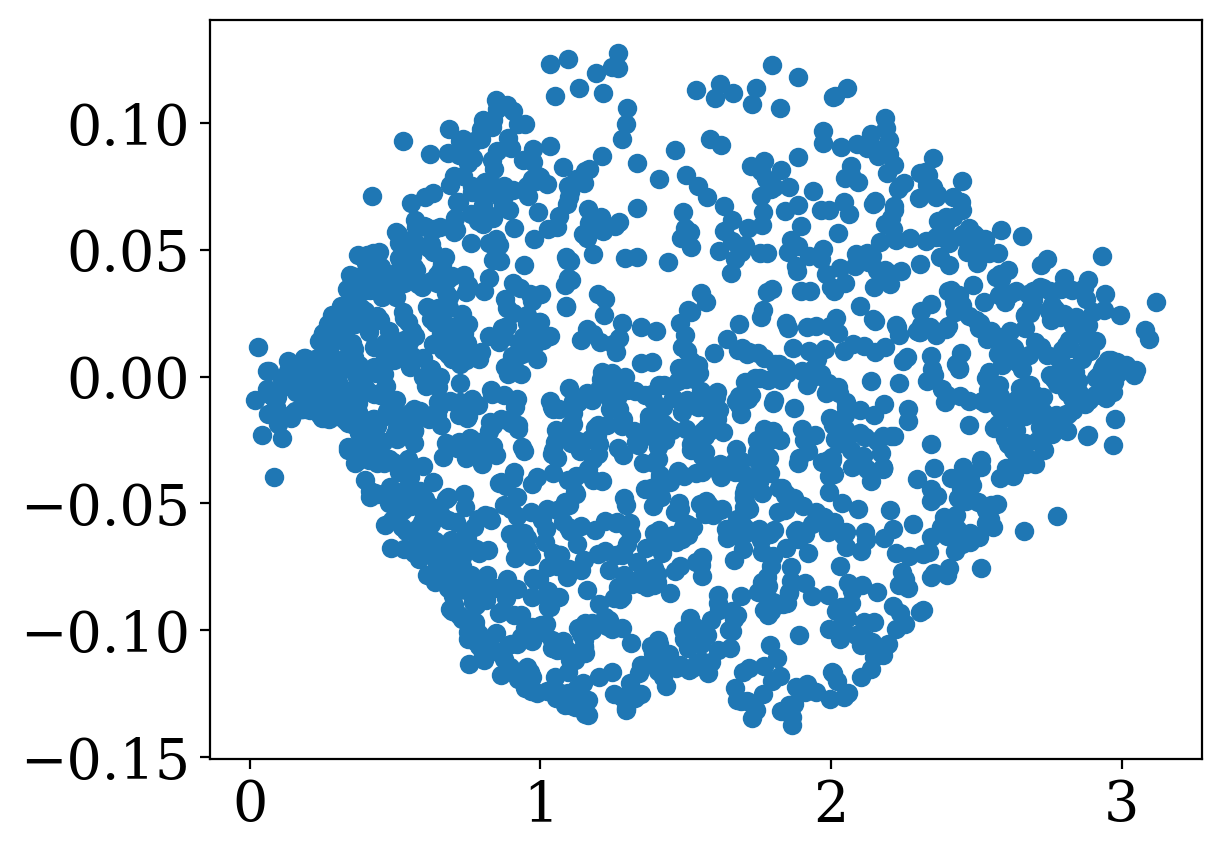

In [57]:
R_21 = np.array(R_21)

plt.plot(alpha_ij, R_21[:,-1]  , 'o')

In [207]:
from scipy.special import sph_harm, lpmv
import scipy

def integral_HD(ell, m):

    def integrand_func(Theta, Phi, psi=0):

        pi = np.array([0, 0, 1])
        tzeta = np.random.uniform(0, np.pi)
        pj = np.array([np.sin(tzeta), 0, np.cos(tzeta)])
        Omega_x = np.sin(Theta) * np.cos(Phi)
        Omega_y = np.sin(Theta) * np.sin(Phi)
        Omega_z = np.cos(Theta)
        Omega = np.stack((Omega_x, Omega_y, Omega_z), axis=0) 
        dot_pi_Omega = np.einsum('i,ijk->jk', pi, Omega)
        dot_pj_Omega = np.einsum('i,ijk->jk', pj, Omega)
        eps = 1e-10  

        denom = (1 + dot_pi_Omega) * (1 + dot_pj_Omega) + eps

        term1 = np.dot(pi, pj) - dot_pi_Omega * dot_pj_Omega
        term2 = (1 - dot_pi_Omega) * (1 - dot_pj_Omega)

        return (3/4) * (term1**2 / denom) - (3/8) * term2
    
    def SH(ell, m, theta, phi):
        term1 = np.sqrt((2*ell + 1)/(4*np.pi))
        term2 = np.sqrt(scipy.special.factorial(ell - m) /scipy.special.factorial(ell + m))
        term3 = lpmv(m, ell, np.cos(theta))
        term4 = np.exp(1j * m * phi)
        return np.real(term1 * term2 * term3 * term4)
    
    theta = np.linspace(0.0001, np.pi, 100)
    phi = np.linspace(0.0001, 2*np.pi, 100)

    Theta, Phi = np.meshgrid(theta, phi) 
    integrand = integrand_func(Theta, Phi) * SH(ell, m, Theta, Phi)#* np.sqrt(4* np.pi)
    integral = np.trapezoid(np.trapezoid(integrand*np.sin(Theta), theta, axis=1), phi)
    return integral



In [208]:
R_00 = []
R_10 = []
R_21 = []
R_22 = []
alpha_ij = []
for i in range(int(len(p)/2)):
    for j in range(i+1, int(len(p)/2)):
        alpha_ij.append(np.arccos(np.dot(p[i], p[j])/(np.linalg.norm(p[i])*np.linalg.norm(p[j]))))
        R_00.append(integral_HD( 0, 0))
        R_10.append(integral_HD(1, 0))
        R_21.append(integral_HD(2, 1))
        R_22.append(integral_HD( 2, 2))

In [209]:
R_00 = np.array(R_00)
R_10 = np.array(R_10)
R_21 = np.array(R_21)
R_22 = np.array(R_22)

print(R_10)

[ 2.12515855e-01 -1.28497056e-01 -1.34639104e+00  2.74399709e-01
  2.18006286e-02  2.48619542e-01 -1.02517807e-02 -3.10237756e-02
 -6.90015536e-01  9.35106284e-02 -1.01948599e-01 -3.43717788e-02
 -1.36601243e-01 -1.53346944e+00 -7.54281025e-01  1.15286066e-01
  1.11250594e-02 -3.89206989e-02 -1.22741389e+00  1.82471617e-02
 -1.32571497e-02 -1.15273004e-03 -5.16725814e-02 -4.74207441e-02
 -6.42682072e-02 -5.54530969e-03 -1.31296599e-01 -6.19924021e-03
 -1.02586755e-01  3.20750413e-01 -1.53197661e+00 -1.22676275e-01
 -1.32036794e+00  3.83236247e-02  3.11123208e-01  2.49892943e-02
 -2.84595355e-01  4.93588600e-02 -2.97794490e-02  3.21068456e-01
 -1.82683437e-02 -1.43337480e+00 -6.47176272e-02 -1.20745712e-01
 -1.25320009e+00  3.04430185e-01  4.50245605e-02 -1.24809964e-01
 -1.17284483e-01  6.12595217e-02 -1.35966833e-01 -1.18036751e-01
 -1.25316114e+00 -2.78291053e-02 -2.40402423e-02  2.66184185e-01
  2.56372818e-01 -1.48458393e+00  2.49416987e-01 -1.00128939e-01
 -5.17337786e-04 -1.36260

Text(0.5, 0, 'alpha')

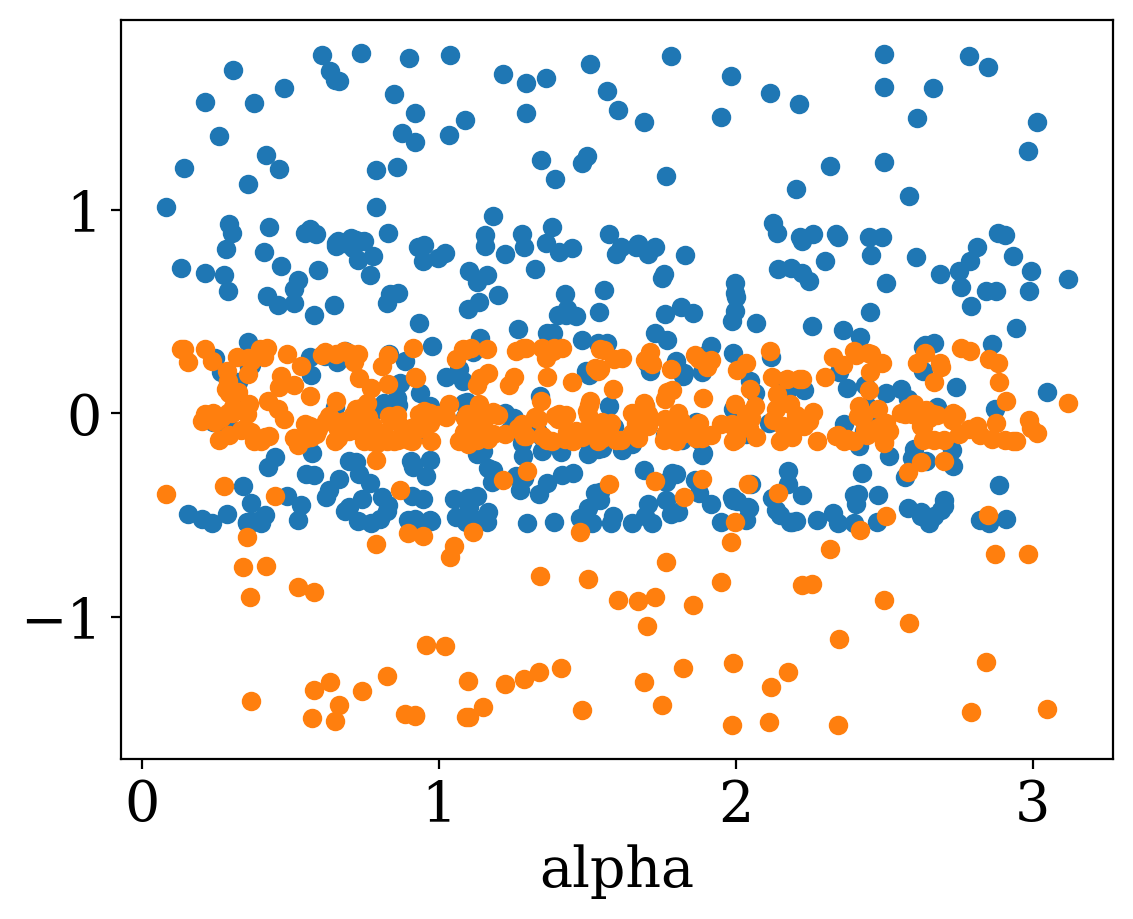

In [210]:
# plot
plt.figure()
plt.plot(alpha_ij, R_00 , 'o')
plt.plot(alpha_ij, np.real(R_10) , 'o')
# plt.plot(alpha_ij, R_21, 'o')
#plt.plot(alpha_ij, np.real(R_22), 'o')
plt.xlabel('alpha')

In [212]:
def get_pulsar_pair(zeta):
    pi = np.array([0, 0, 1])
    pj = np.array([np.sin(zeta), 0, np.cos(zeta)])  # nel piano xz
    return pi, pj

def response_integrand(pi, pj, Theta, Phi):
    # unit vector in propagation direction
    Omega = np.array([
        np.sin(Theta) * np.cos(Phi),  # x
        np.sin(Theta) * np.sin(Phi),  # y
        np.cos(Theta)                 # z
    ])  # shape (3, n_theta, n_phi)

    # dot product of pulsars with Omega
    pi_dot_Omega = np.tensordot(pi, Omega, axes=([0], [0]))  # shape (n_theta, n_phi)
    pj_dot_Omega = np.tensordot(pj, Omega, axes=([0], [0]))

    # denominatore regolarizzato
    eps = 1e-10
    denom = (1 + pi_dot_Omega) * (1 + pj_dot_Omega) + eps

    # termini dell'integrando
    dot_pipj = np.dot(pi, pj)
    term1 = dot_pipj - pi_dot_Omega * pj_dot_Omega
    term2 = (1 - pi_dot_Omega) * (1 - pj_dot_Omega)

    return (3/4) * (term1**2 / denom) - (3/8) * term2

def sph_proj_integral(pi, pj, ell, m, n_theta=100, n_phi=100):
    theta = np.linspace(1e-4, np.pi - 1e-4, n_theta)
    phi = np.linspace(1e-4, 2 * np.pi - 1e-4, n_phi)
    Theta, Phi = np.meshgrid(theta, phi, indexing='ij')  # shape (n_theta, n_phi)

    integrand = response_integrand(pi, pj, Theta, Phi)
    Y_lm = sph_harm(m, ell, Phi, Theta)

    full_integrand = integrand * np.real(Y_lm) * np.sin(Theta)

    # doppia integrazione
    integral_theta = np.trapz(full_integrand, theta, axis=0)
    total_integral = np.trapz(integral_theta, phi)

    return total_integral

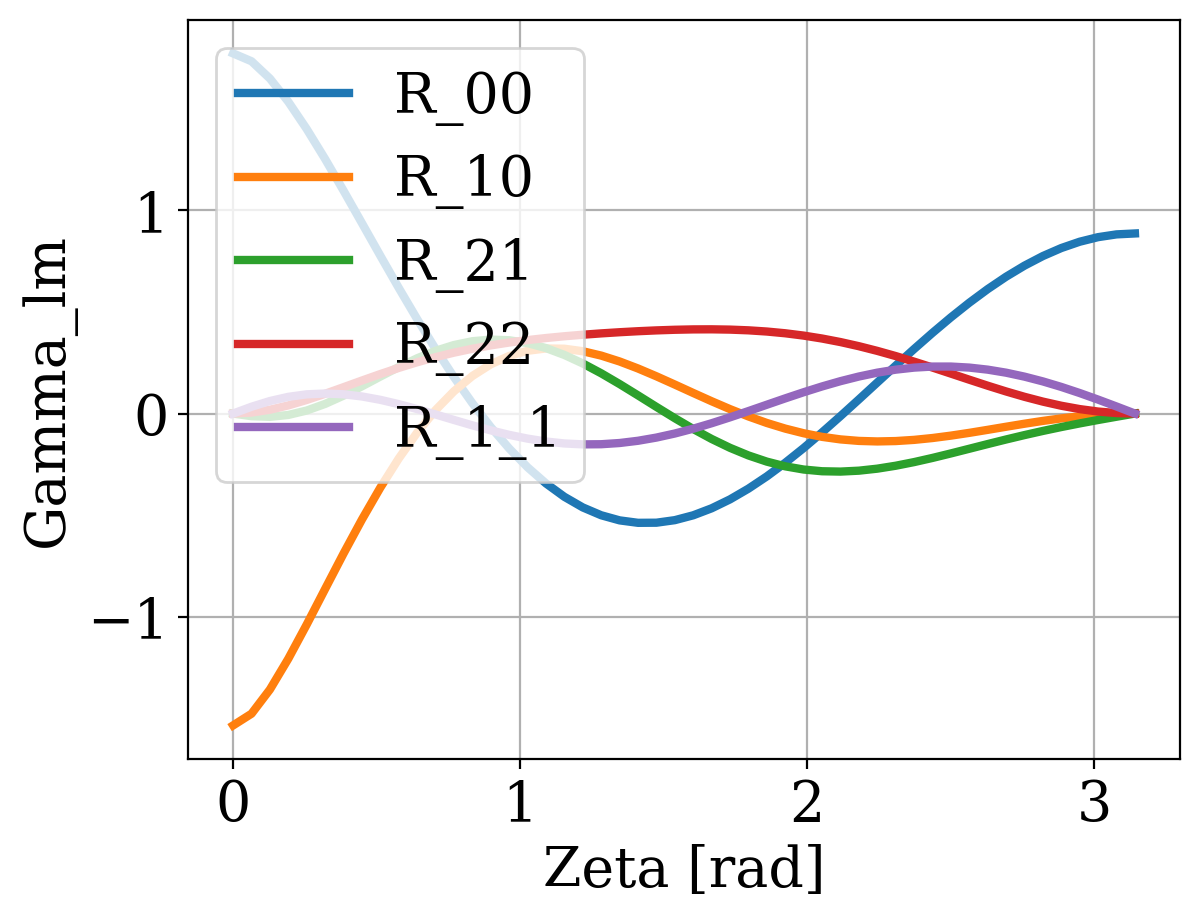

In [215]:
zetas = np.linspace(0, np.pi, 50)
R00 = []
R10 = []
R21 = []
R_22 = []
R_1_1 = []

for zeta in zetas:
    pi, pj = get_pulsar_pair(zeta)
    R00.append(sph_proj_integral(pi, pj, 0, 0))
    R10.append(sph_proj_integral(pi, pj, 1, 0))
    R21.append(sph_proj_integral(pi, pj, 2, 1))
    R_22.append(sph_proj_integral(pi, pj, 2, 2))
    R_1_1.append(sph_proj_integral(pi, pj, 1, 1))

import matplotlib.pyplot as plt
plt.plot(zetas, R00, label='R_00')
plt.plot(zetas, R10, label='R_10')
plt.plot(zetas, R21, label='R_21')
plt.plot(zetas, R_22, label='R_22')
plt.plot(zetas, R_1_1, label='R_1_1')
plt.xlabel('Zeta [rad]')
plt.ylabel('Gamma_lm')
plt.legend()
plt.grid(True)
plt.show()


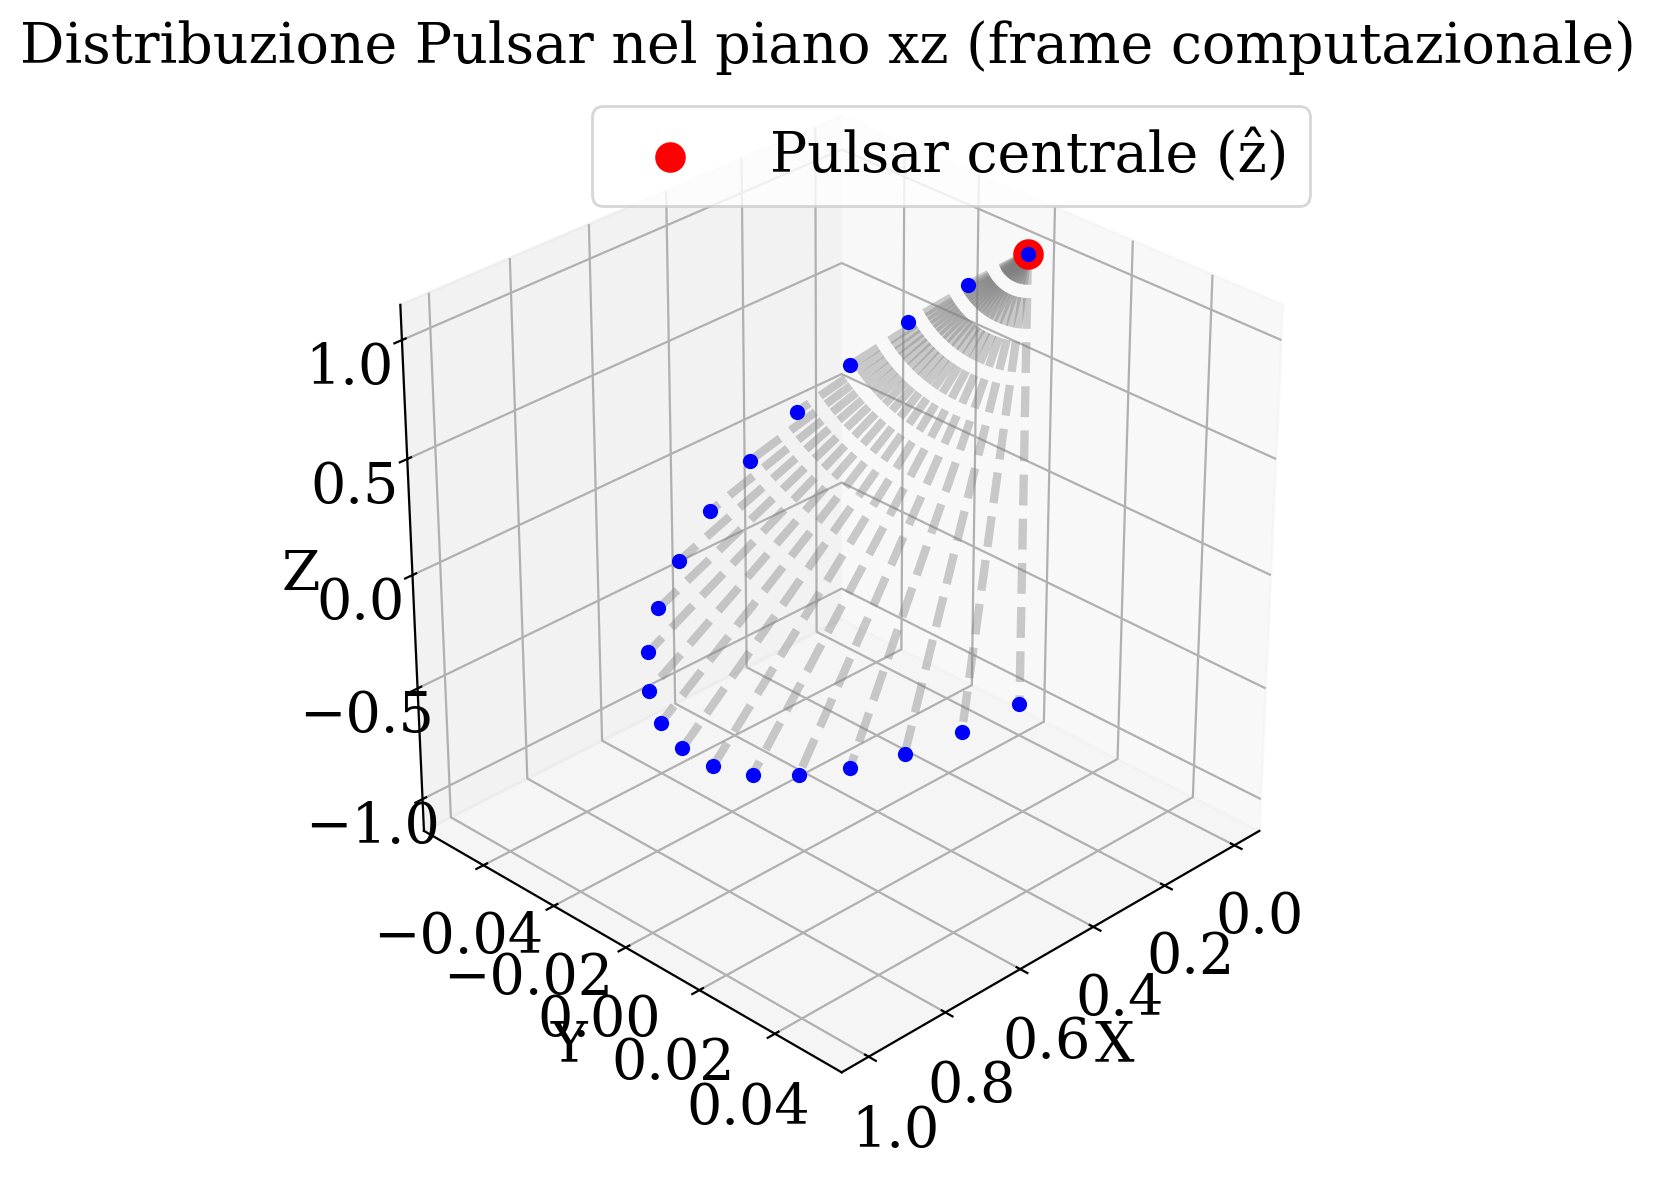

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pulsar lungo z
pi = np.array([0, 0, 1])

# Altre pulsar a varie zeta nel piano xz
zetas = np.linspace(0, np.pi, 20)
pulsars = [np.array([np.sin(z), 0, np.cos(z)]) for z in zetas]

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Pulsar centrale
ax.scatter(*pi, color='red', s=100, label='Pulsar centrale (ẑ)')

# Altre pulsar
for pj in pulsars:
    ax.scatter(*pj, color='blue')
    ax.plot([pi[0], pj[0]], [pi[1], pj[1]], [pi[2], pj[2]], color='gray', linestyle='--', alpha=0.4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Distribuzione Pulsar nel piano xz (frame computazionale)")
ax.legend()
ax.view_init(elev=30, azim=45)
ax.set_box_aspect([1,1,1])  # Render isotropo

plt.tight_layout()
plt.show()


In [ ]:
# evaluate all the angular separation between a set of pulsar by just fixing the first one

def get_pulsar_pair(zeta):
    pi = np.array([0, 0, 1])
    pj = np.array([np.sin(zeta), 0, np.cos(zeta)])  # nel piano xz
    return pi, pj


In [231]:
def get_pulsar_pair(zeta):
    pi = np.array([0, 0, 1])
    pj = np.array([np.sin(zeta), 0, np.cos(zeta)])  # nel piano xz
    return pi, pj

R_V = []
Di = Dj = d[0]
print(Di, Dj)
f = np.logspace(-9, -7, 100)
for zeta in zetas:
    pi, pj = get_pulsar_pair(zeta)
    R_V.append(Response.pairwise_overlap(f, pi, pj, Di, Dj, 't'))
   

3.380934335923993e+19 3.380934335923993e+19


In [232]:
R_V = np.array([R_V])
print(R_V.shape)

(1, 50, 100)


In [233]:
print(R_V[0, 0, :])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


In [ ]:
N, pulsar_xyz, d = detectors.get_NANOGrav_pulsars()

In [78]:

f = np.logspace(-9, -7, 100)
gamma1_ij_t = []
gamma0_ij_t = []
gamma2_ij_t = []

alpha_ij = []
ell=0
psi = 0
for i in range(int(N/4)):
    for j in range(i+1, int(N/4)):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma0_ij_t.append(AngularResponse.R_ell_pairwise(0, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 't', psi))
        gamma1_ij_t.append(AngularResponse.R_ell_pairwise(1, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 't', psi))
        gamma2_ij_t.append(AngularResponse.R_ell_pairwise(2, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 't', psi))

gamma0_ij_t = np.array(gamma0_ij_t)
gamma1_ij_t = np.array(gamma1_ij_t)
gamma2_ij_t = np.array(gamma2_ij_t)
alpha_ij = np.array(alpha_ij)

(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)
(100,)
(100, 196608)

In [73]:
print(gamma1_ij_t.shape)

(105, 100)


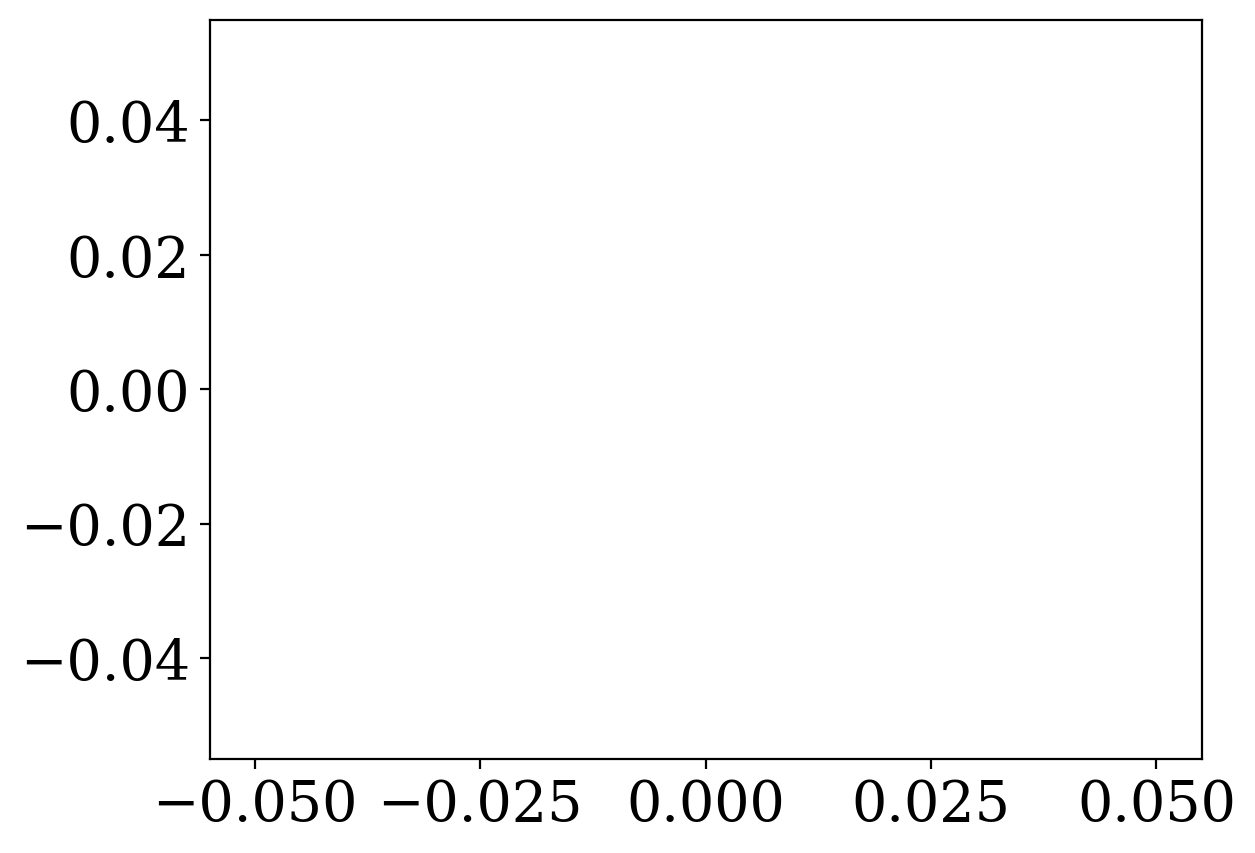

In [286]:
plt.plot(f, R1_t[0, :], label='R1_t')

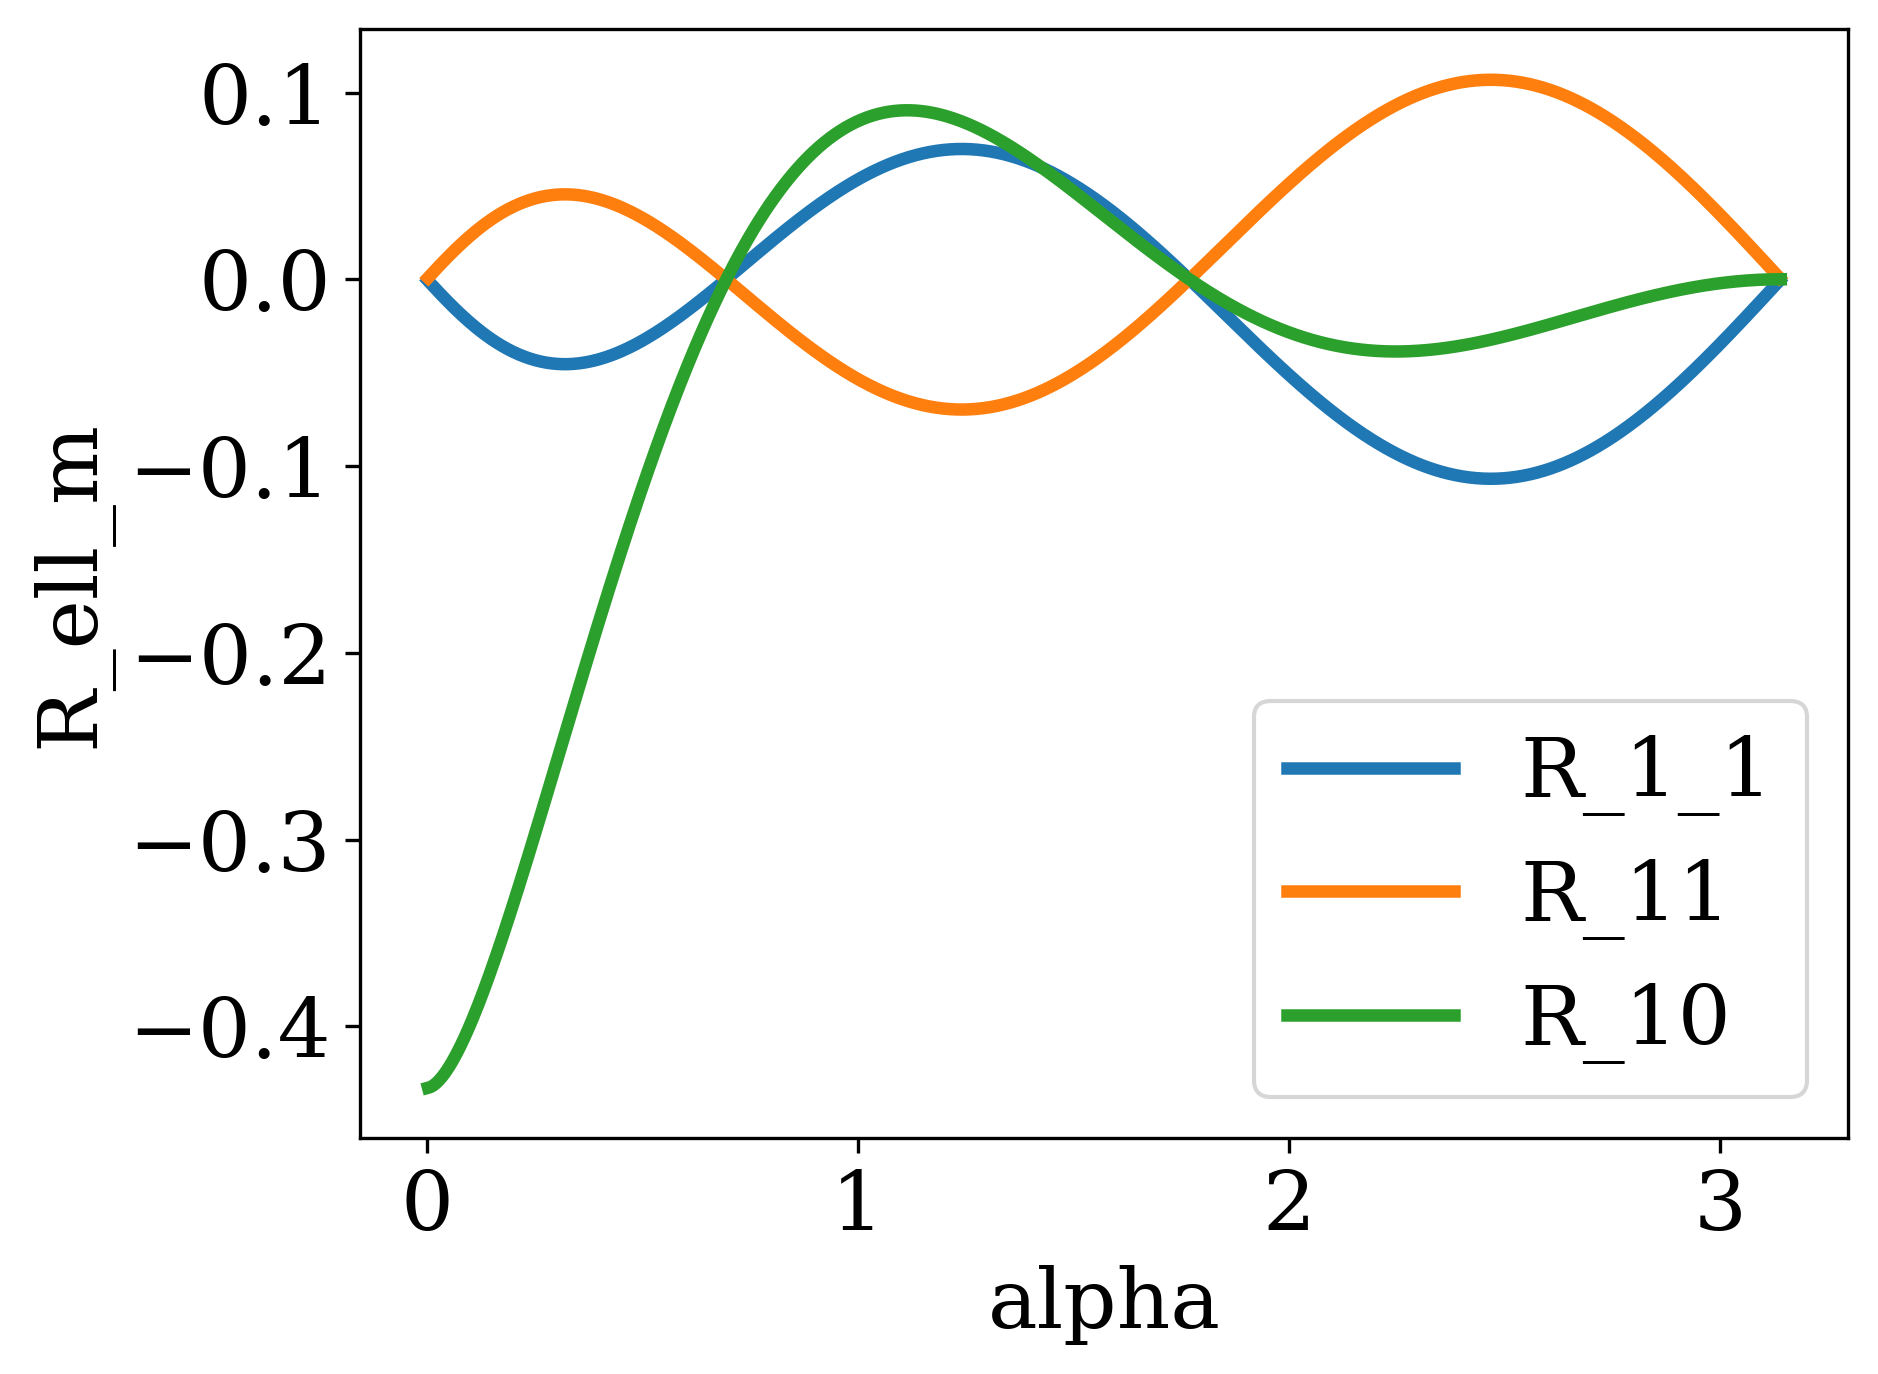

In [111]:
def R_1_1(alpha):
    term1 = -np.sin(alpha)/4
    term2 =  3*(1-np.cos(alpha))
    term3 = (1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2)))
    return term1 * (1+term2*term3)

def R_11(alpha):
    term1 = np.sin(alpha)/4
    term2 =  3*(1-np.cos(alpha))
    term3 = 1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (1+term2*term3)
    
def R_10(alpha):
    term1 = -np.sqrt(3)/8
    term2 = 1+ np.cos(alpha)
    term3= 3 * (1-np.cos(alpha))
    term4 = 4*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3 * (term2 + term4))

alpha = np.linspace(0, np.pi, 1000)

plt.plot(alpha, R_1_1(alpha), label='R_1_1')
plt.plot(alpha, R_11(alpha), label='R_11')
plt.plot(alpha, R_10(alpha), label='R_10')
plt.xlabel('alpha')
plt.ylabel('R_ell_m')
plt.legend()



In [82]:
def hellings_downs(alpha):
    return 0.5 + (3*(1- np.cos(alpha))/4 * (np.log(0.5*(1-np.cos(alpha)))- 1/6))


In [107]:
def R_22(alpha):
    term1 = -0.25 * np.sqrt(5*np.pi/6) * (1-np.cos(alpha))/(1+ cos(alpha))
    term2 = (1+ np.cos(alpha)) *((np.cos(alpha))**2 + 4* np.cos(alpha)-9)
    term3 = -24 * (1-cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)  

def R_21(alpha):
    term1 = 0.25*np.sqrt(2*np.pi/15)*np.sin(alpha)
    term2 = 5*(np.cos(alpha)**2) + 15*np.cos(alpha) -21
    term3 = -60*(1-np.cos(alpha))/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_20(alpha):
    term1 = np.sqrt(np.pi/5)/3
    term2 = np.cos(alpha) 
    term3 = 15*(1-np.cos(alpha))/4
    term4 = (1+np.cos(alpha))*(np.cos(alpha)+3) + 8*np.log(np.sin(alpha/2))
    return term1*(term2 + term3*term4)

def R_2_2(alpha):
    return - R_22(alpha)

def R_2_1(alpha):
    return - R_21(alpha)

def R_2_fit(alpha):
    term1 = R_2_2(alpha)
    term2 = R_2_1(alpha)
    term3 = R_20(alpha)
    term4 = R_21(alpha)
    term5 = R_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

    

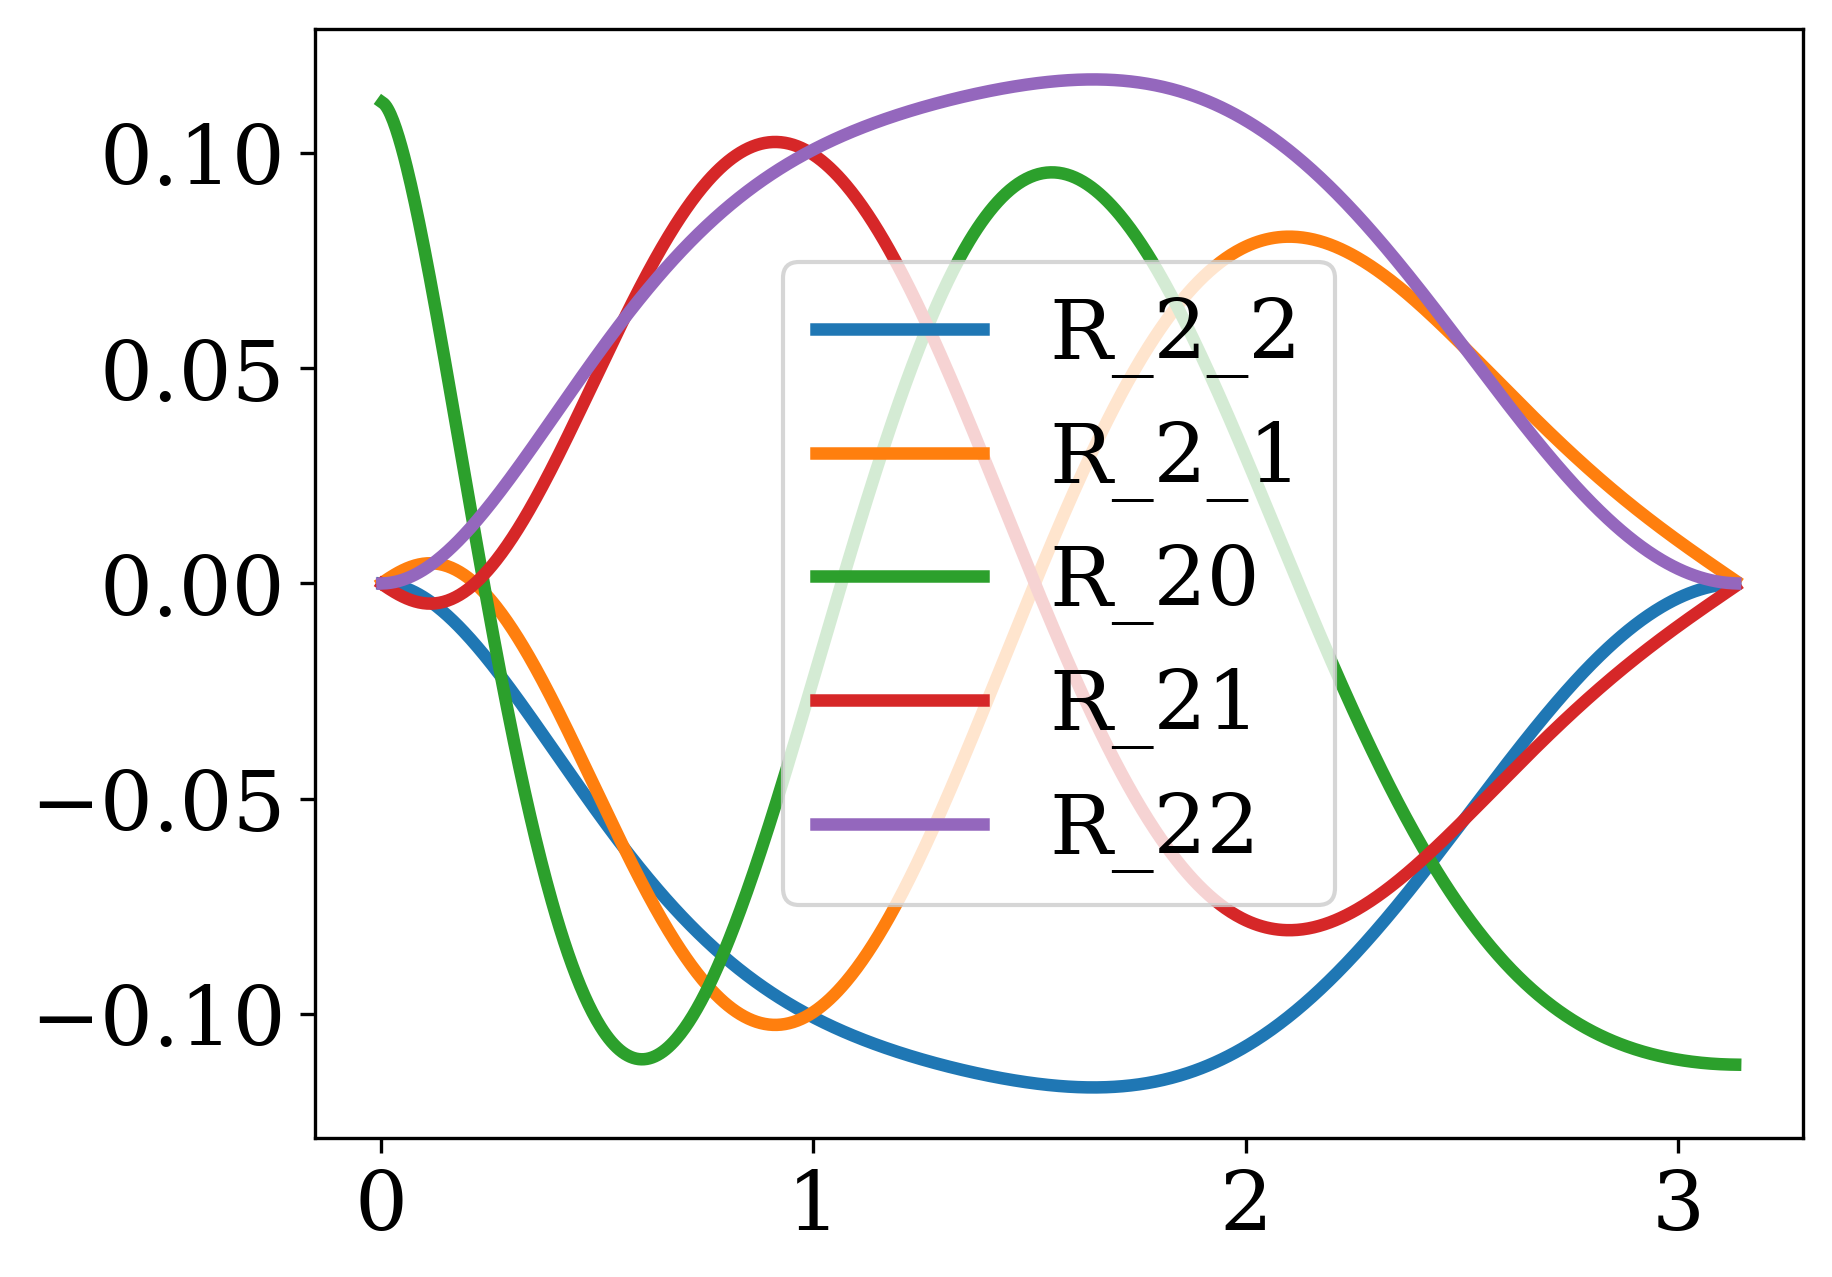

In [108]:
# plot all the functions

alpha = np.linspace(0, np.pi-0.01, 1000)

plt.figure()
plt.plot(alpha, R_2_2(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_2_2')
plt.plot(alpha, R_2_1(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_2_1')
plt.plot(alpha, R_20(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_20')
plt.plot(alpha, R_21(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_21')
plt.plot(alpha, R_22(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_22')
plt.legend()


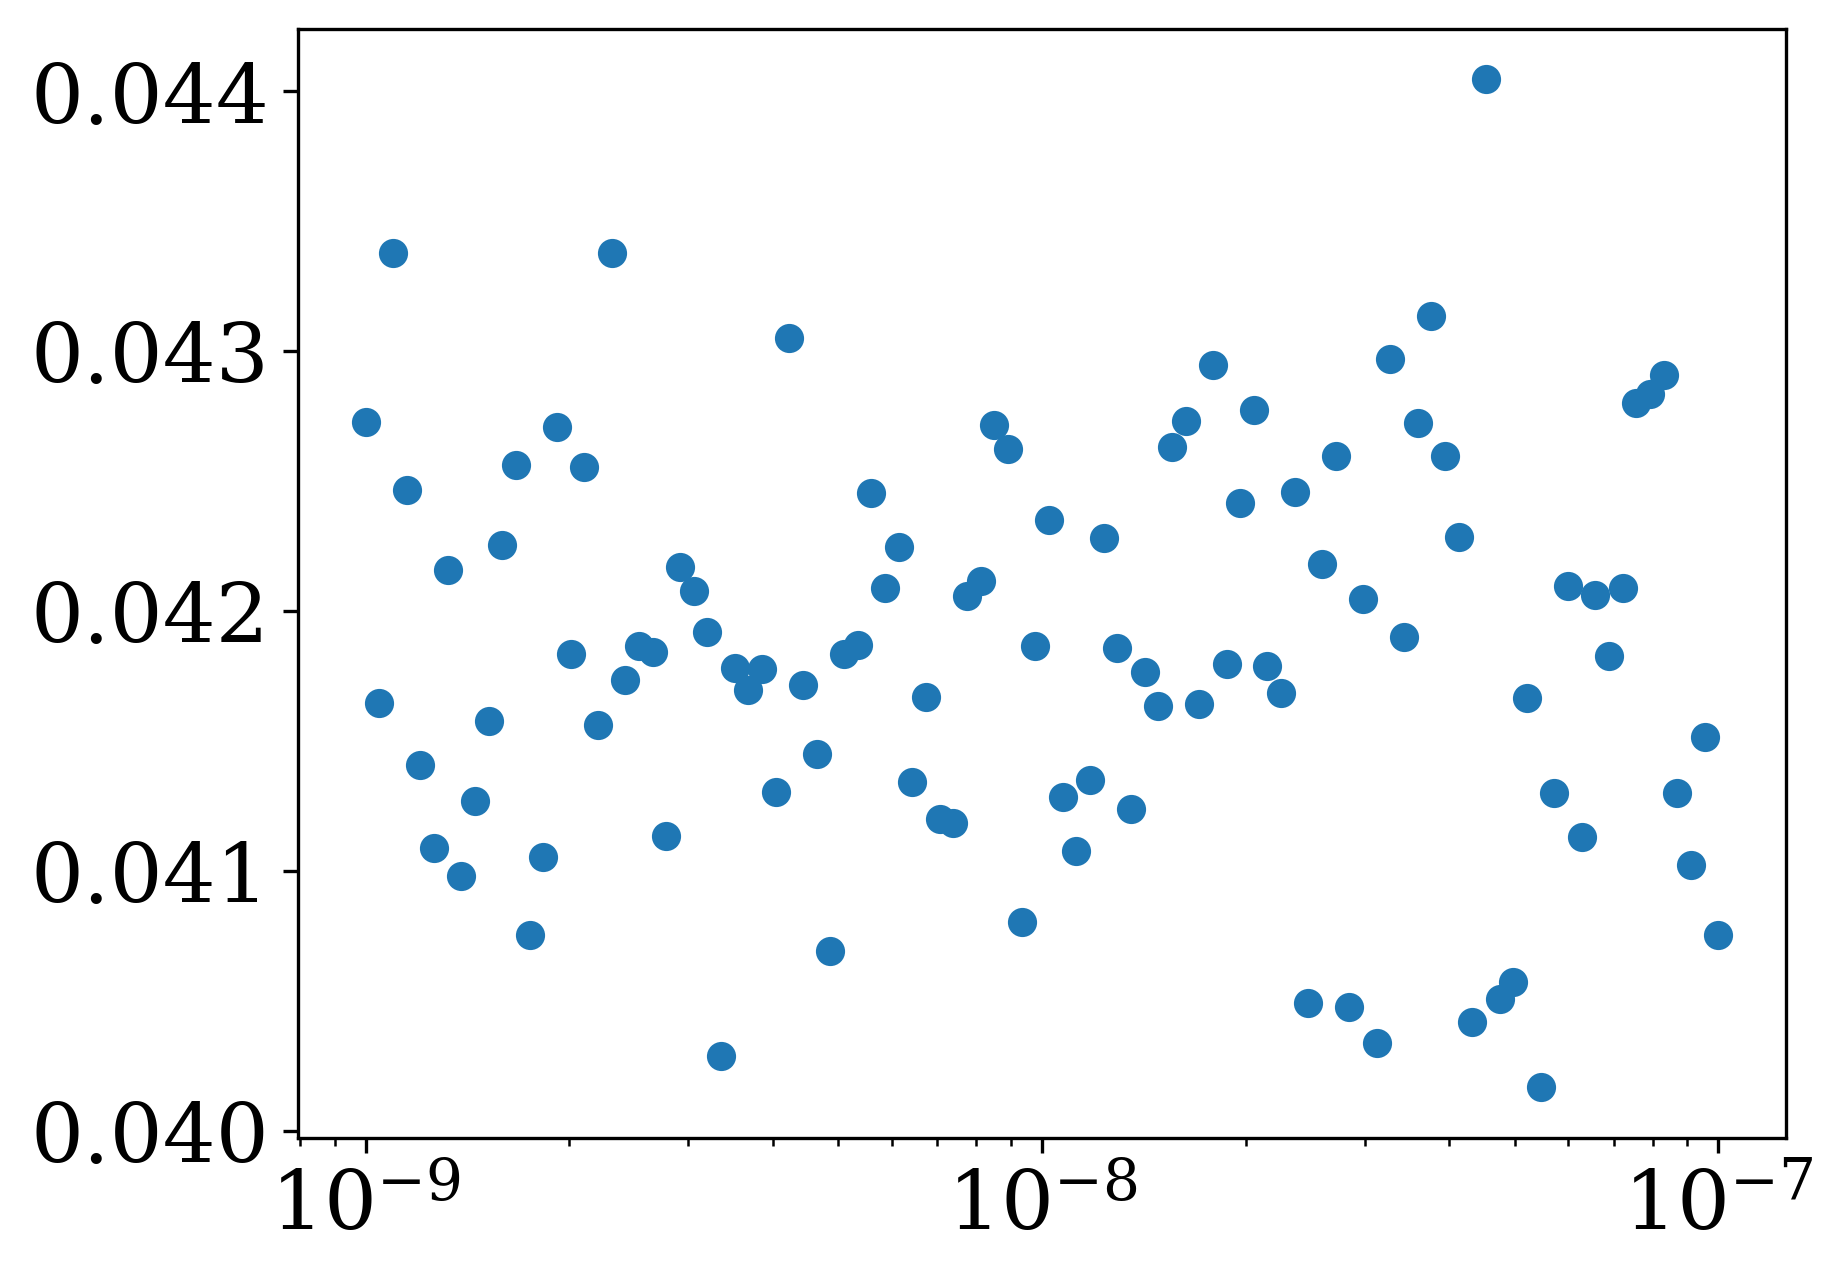

In [110]:
#gamma0_ij_t[:,0]
plt.plot(f, gamma0_ij_t[0,:], 'o', label='gamma0_ij_t')
plt.xscale('log')


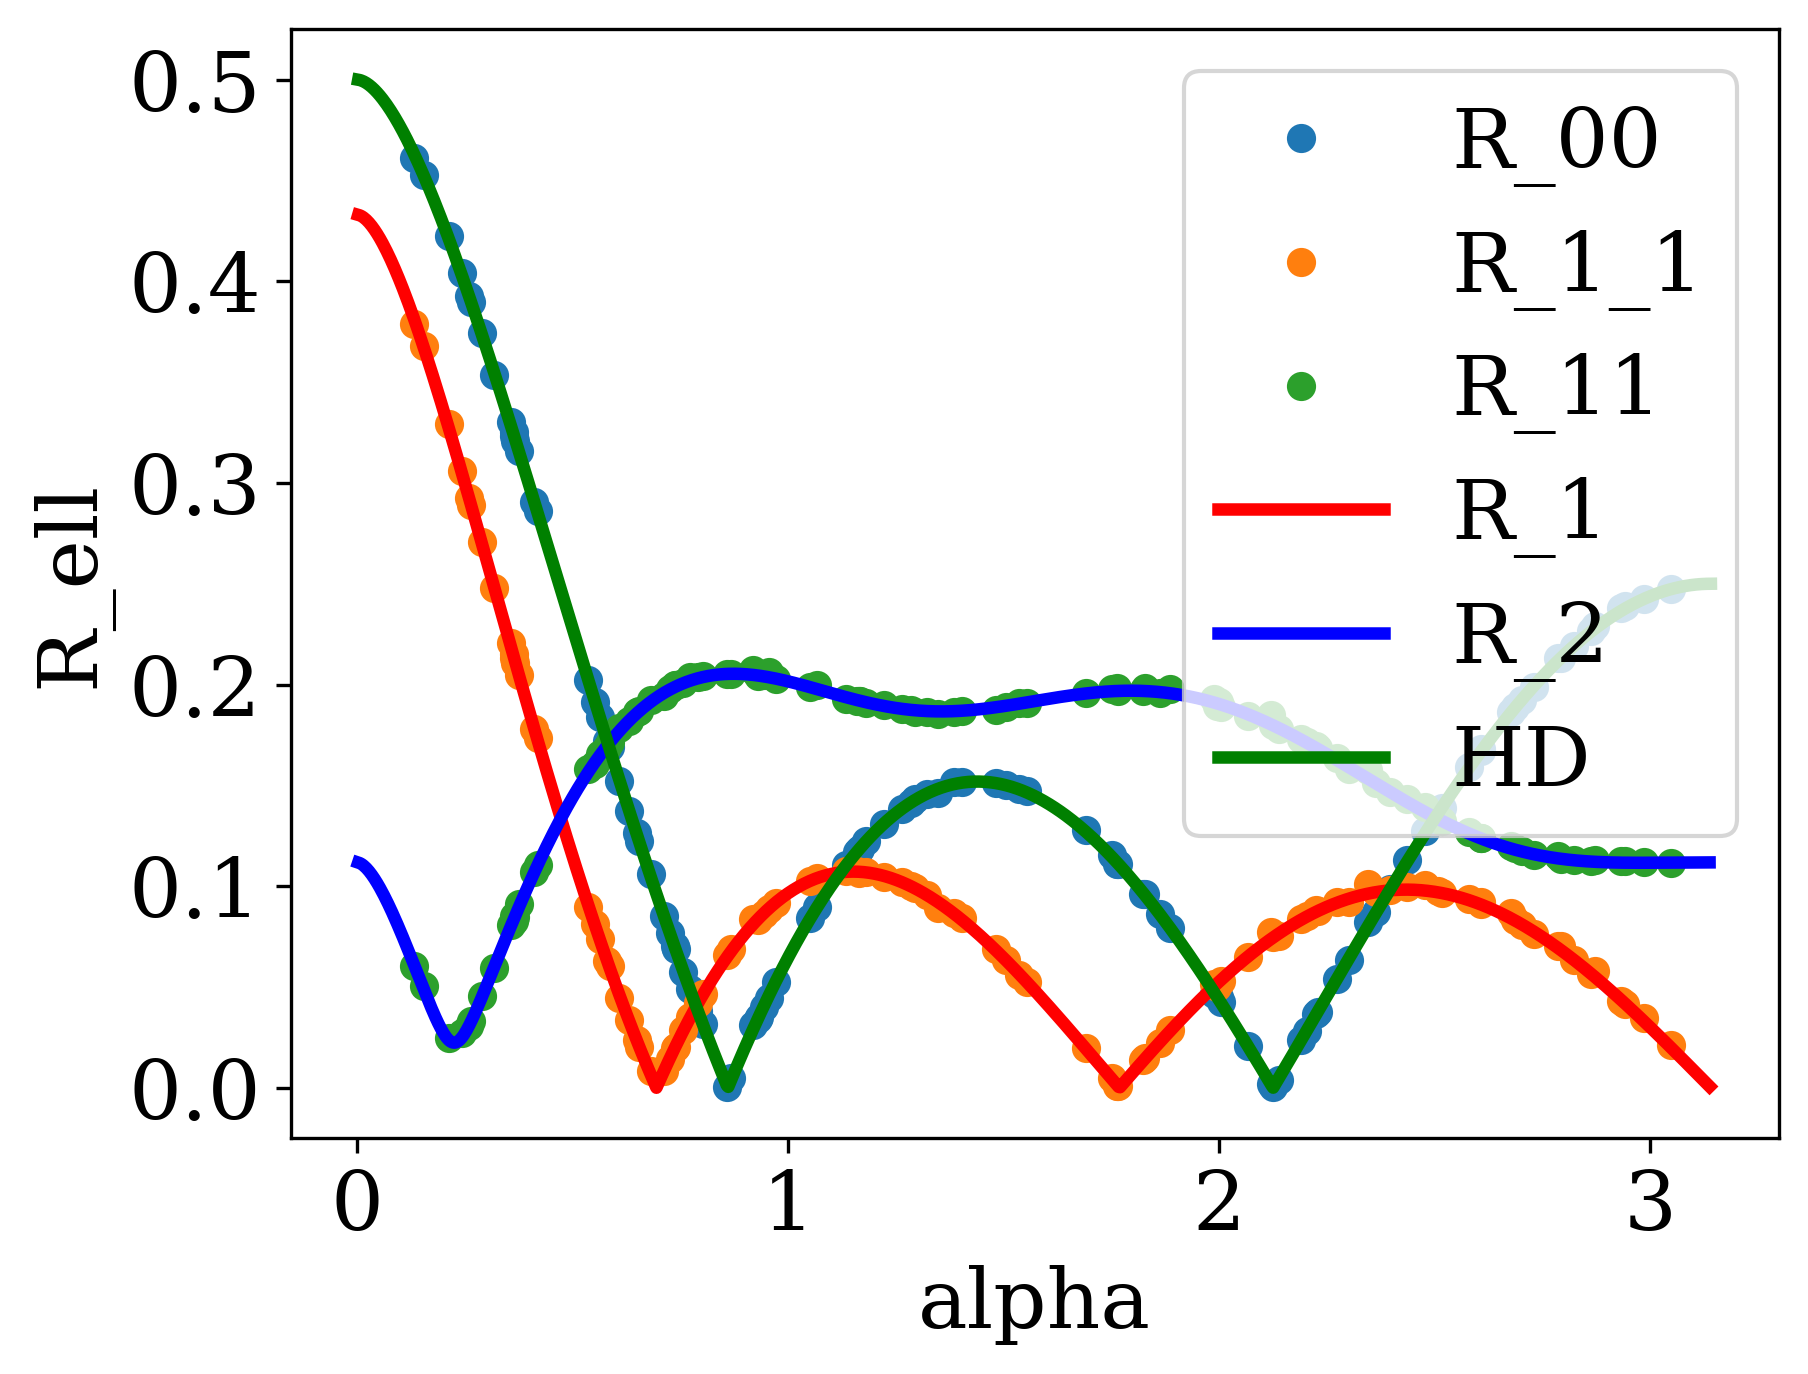

In [109]:
def R_1(alpha):
    term1 = R_1_1(alpha)
    term2 = R_11(alpha)
    term3 = R_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

alpha = np.linspace(0, np.pi, 1000)

plt.figure()
plt.plot(alpha_ij, gamma0_ij_t[:,0], 'o', label='R_00')
plt.plot(alpha_ij, gamma1_ij_t[:,0], 'o', label='R_1_1')
plt.plot(alpha_ij, gamma2_ij_t[:,0], 'o', label='R_11')
plt.plot(alpha, R_1(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_1', color='red') 
plt.plot(alpha, R_2_fit(alpha)*(3/(8*np.pi)*np.sqrt(4*np.pi)), label='R_2', color='blue')
plt.plot(alpha, np.abs(hellings_downs(alpha)), label='HD', color='green')  
plt.xlabel('alpha')
plt.ylabel('R_ell')
plt.legend()

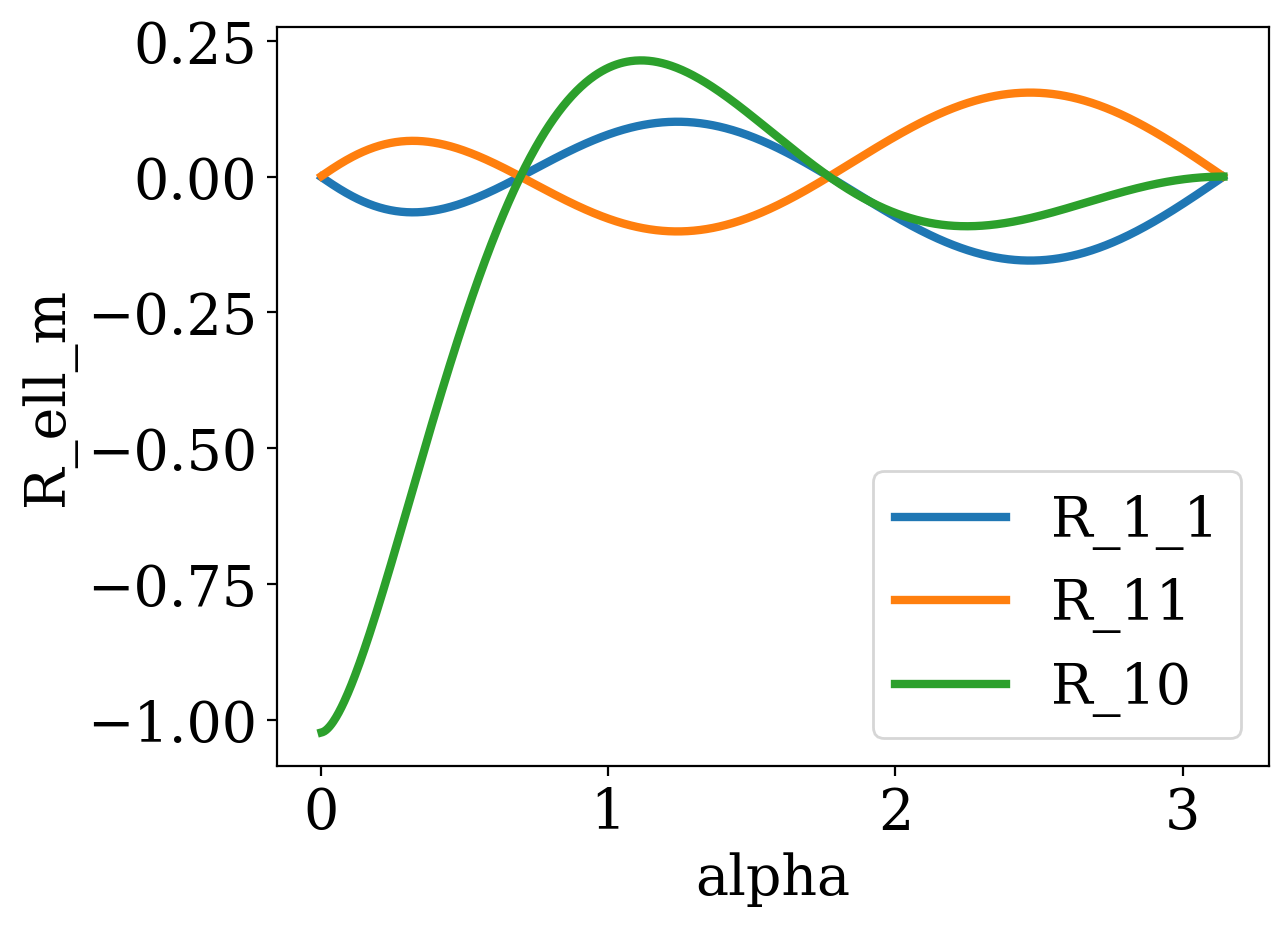

In [21]:
# https://arxiv.org/pdf/1306.5394

def R_1_1(alpha):
    term1 = -0.5* np.sqrt(np.pi/6)*np.sin(alpha)
    term2 =  3*(1-np.cos(alpha))
    term3 = (1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2)))
    return term1 * (1+term2*term3)
    #return  -np.sin(alpha)/16 * ( 1+ ( 3*(1-np.cos(alpha)))*(1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2))) )


def R_11(alpha):
    return  -R_1_1(alpha) 


def R_10(alpha):
    term1 =-0.5 *np.sqrt(np.pi/3)
    term2 = 1+ np.cos(alpha)
    term3= 3 * (1-np.cos(alpha))
    term4 = 4*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3 * (term2 + term4))

alpha = np.linspace(0, np.pi, 1000)

plt.plot(alpha, R_1_1(alpha), label='R_1_1')
plt.plot(alpha, R_11(alpha), label='R_11')
plt.plot(alpha, R_10(alpha), label='R_10')
plt.xlabel('alpha')
plt.ylabel('R_ell_m')
plt.legend()


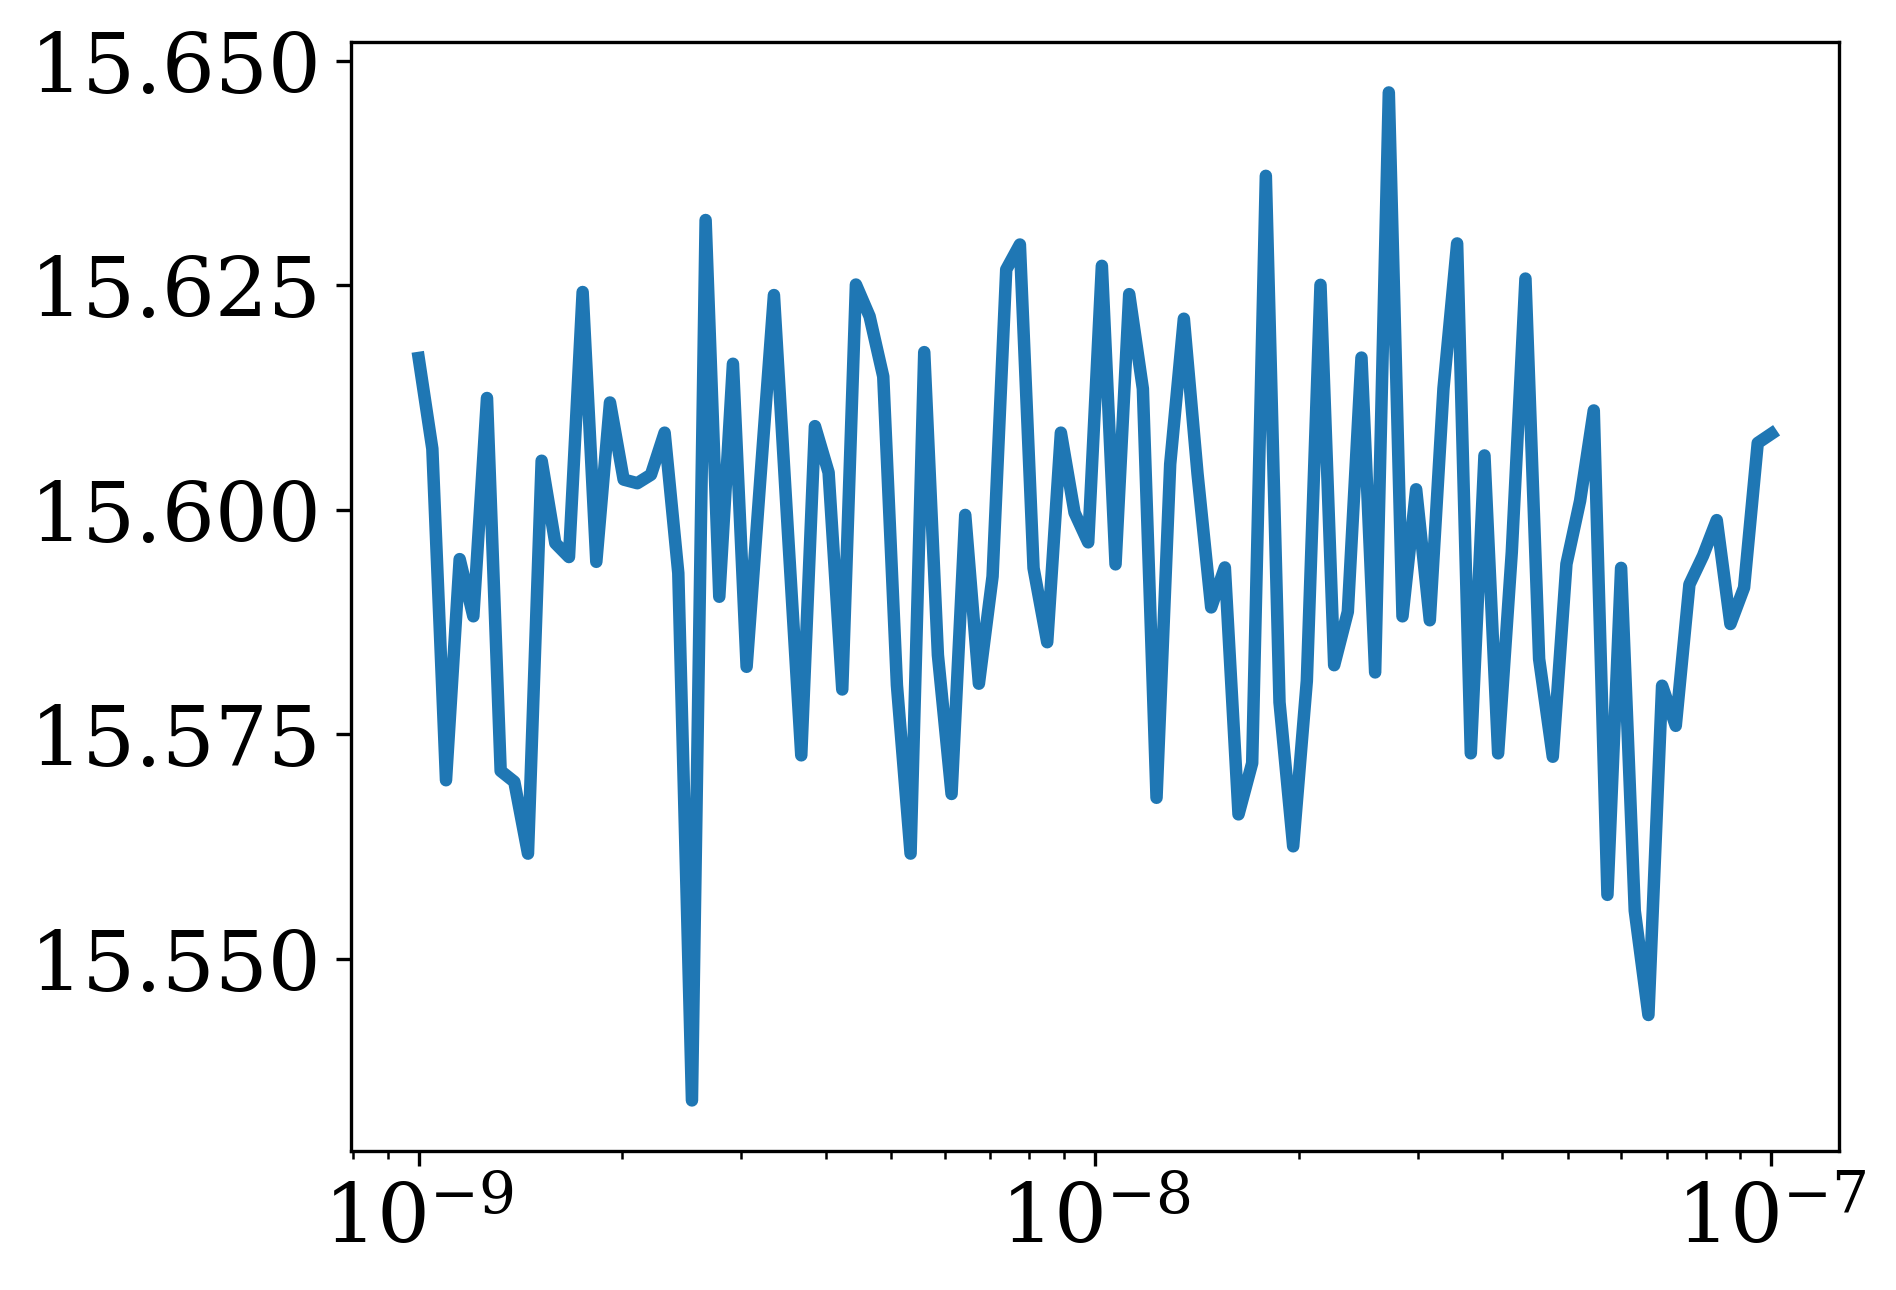

In [74]:
gamma_ij_1_tot = np.sum(gamma1_ij_t, axis=0)

plt.figure()
plt.plot(f, gamma_ij_1_tot, label='gamma_ij_1_tot')
plt.xscale('log')

0.5077206722824283


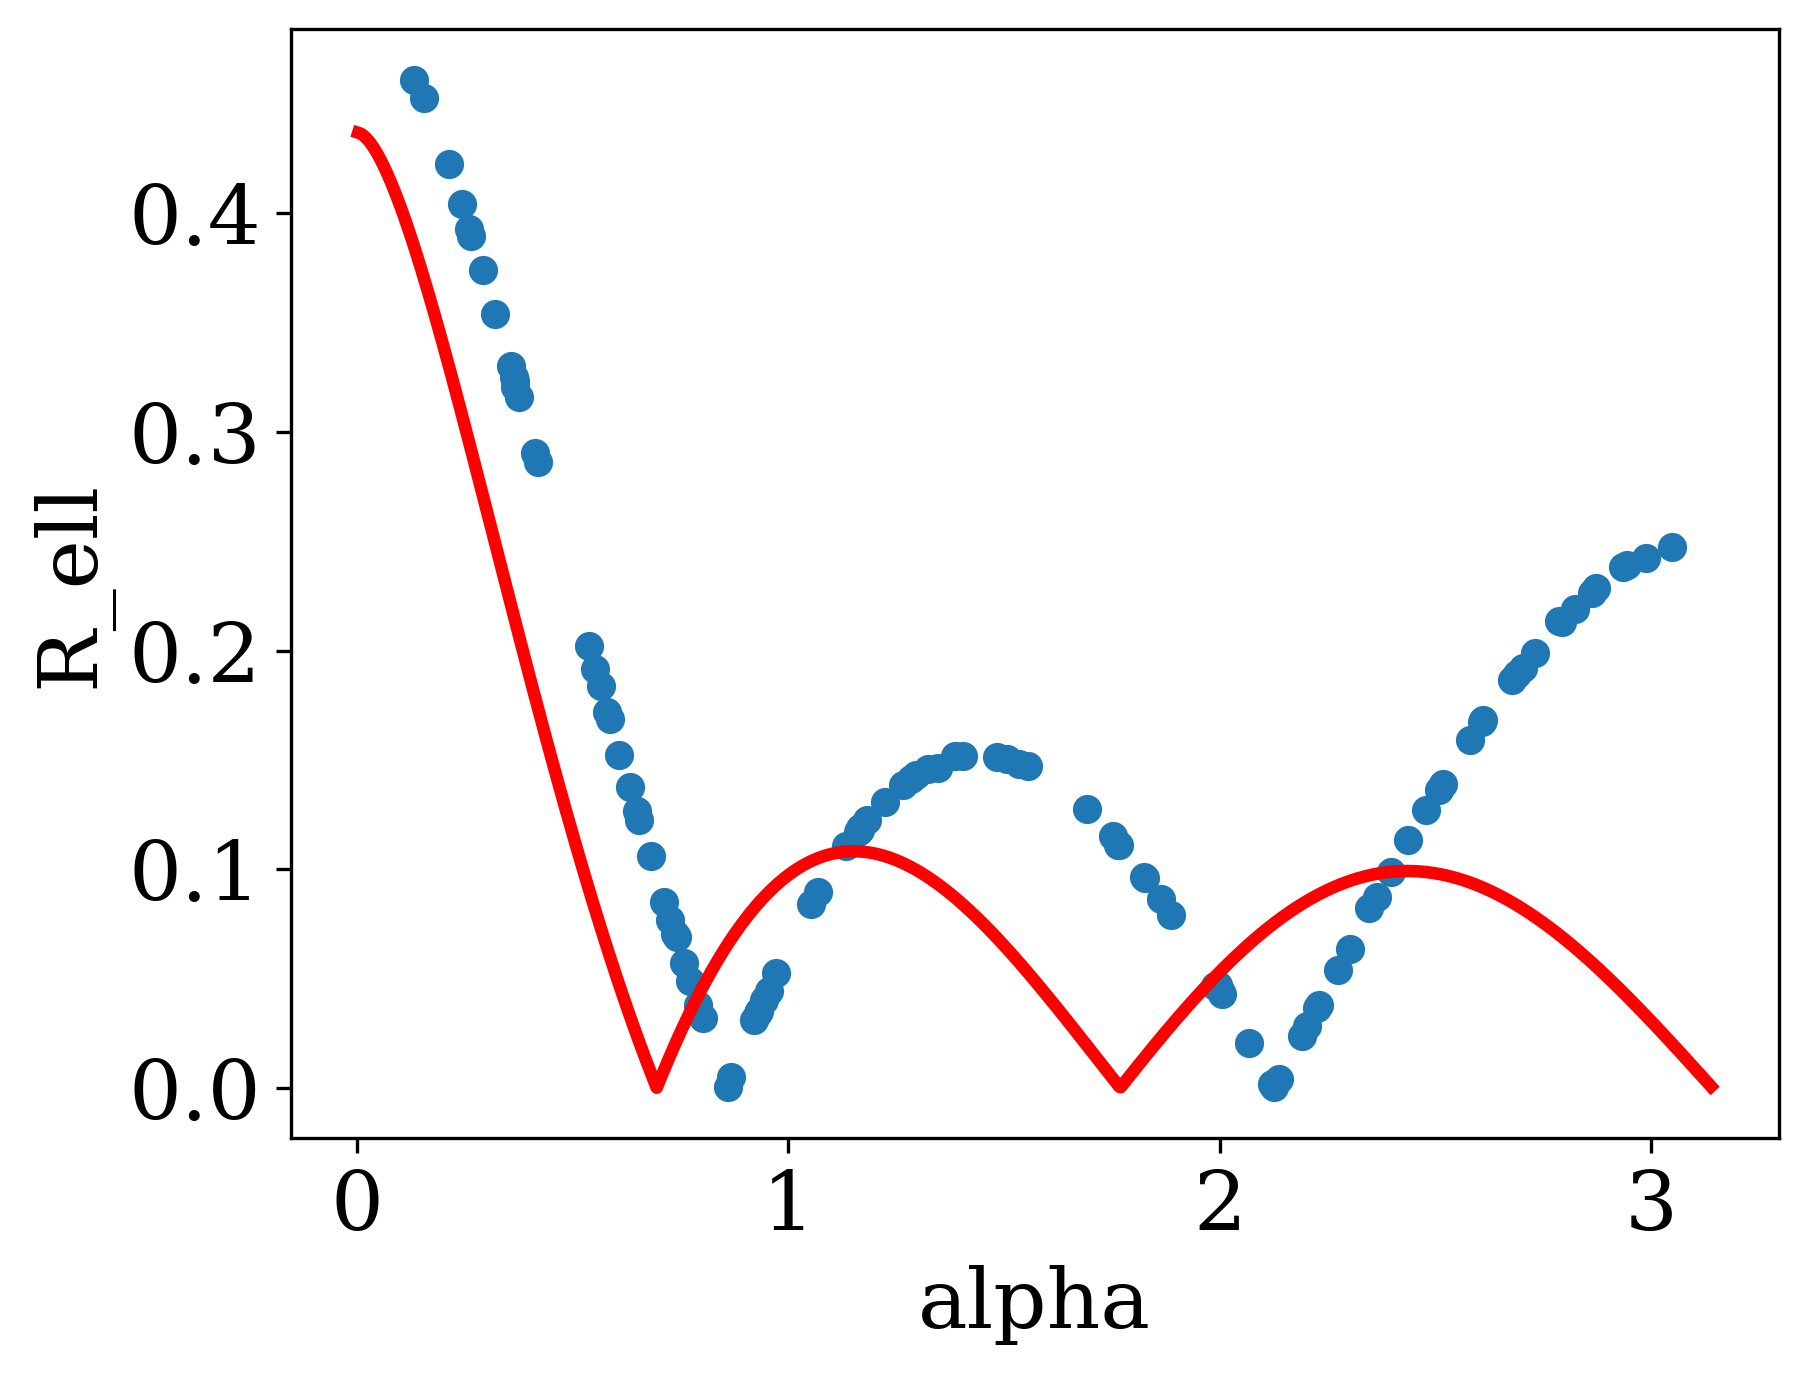

In [75]:
def R_1(alpha):
    term1 = R_1_1(alpha)
    term2 = R_11(alpha)
    term3 = R_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

alpha = np.linspace(0, np.pi, 1000)

plt.plot(alpha_ij, gamma1_ij_t[:,0], 'o', label='R_1_1')
plt.plot(alpha, R_1(alpha)/2.342420521182274, label='R_1', color='red')   
plt.xlabel('alpha')
plt.ylabel('R_ell')

print(1/np.mean( gamma1_ij_t[:,0]/R_1(alpha_ij)))

In [56]:
print(gamma1_ij_t.shape)

(105,)


In [20]:
A_mingarelli = -0.5 * np.sqrt(np.pi/6)
A_mauro = -1/16
B_mingarelli = -0.5*np.sqrt(np.pi/3)
B_mauro = -np.sqrt(3)/8

print(A_mingarelli/A_mauro)
print(B_mingarelli/B_mauro)

print(A_mingarelli/B_mingarelli)
print(A_mauro/B_mauro)

5.788810036466141
2.363271801207355
0.7071067811865475
0.2886751345948129
